In [1]:
%matplotlib inline
import numpy as np
import pylab as plt
from matplotlib.gridspec import GridSpec
from astropy.table import Table, vstack, Column, MaskedColumn
from astropy import units as u
from scipy.stats import kde
from scipy.stats import binned_statistic as b_s
from scipy.stats import binned_statistic_2d as bs2d
from astropy import units as un
from astropy import constants as con
from matplotlib.lines import Line2D

from astropy.cosmology import Planck15
from tqdm import trange
from scipy.stats import ks_2samp
from scipy import special

import os
os.environ['PATH'] = os.environ['PATH'] + ':/usr/texbin'

plt.rc('path', simplify=True)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize='xx-large', facecolor='none', linewidth=0.7)
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')
plt.rc('lines', markersize=4, linewidth=1, markeredgewidth=0.2)
plt.rc('legend', numpoints=1, frameon=False, handletextpad=0.3, scatterpoints=1, handlelength=2, handleheight=0.1)
#plt.rc('savefig', facecolor='none', frameon='False')

params =   {'font.size' : 16,
            'xtick.major.size': 8,
            'ytick.major.size': 8,
            'xtick.minor.size': 3,
            'ytick.minor.size': 3,
            }
plt.rcParams.update(params) 

np.warnings.filterwarnings('ignore')

def legend_outside_plot(ax,location='top',ncol=3,pad=0, handles=None, labels=None):
    if handles==None:
        handles, labels = ax.get_legend_handles_labels()
    if location=='top':
        leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(0,1.02+pad,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=ncol)
    else:
        print("Location",location,"not implemented. Please code up")
    return leg


In [2]:
data = Table.read('data.txt', format = 'ascii' )

In [3]:
data.rename_column('col1', 'RAdeg')  
data.rename_column('col2', 'DEdeg') 
data.rename_column('col3', 'Imag') 
data.rename_column('col4', 'S')  
data.rename_column('col5', 'zspec') 
data.rename_column('col6', 'N')  
data.rename_column('col7', 'zG')  
data.rename_column('col8', 'chi2G')  
data.rename_column('col9', 'LEll')  
data.rename_column('col10', 'LSbc') 
data.rename_column('col11', 'LIrr')
data.rename_column('col12', 'zGA') 
data.rename_column('col13', 'chi2GA') 
data.rename_column('col14', 'LAGNp') 
data.rename_column('col15', 'LELLp') 
data.rename_column('col16', 'LSbcp') 
data.rename_column('col17', 'LIrrp') 
data.rename_column('col18', 'F') 
data.rename_column('col19', 'EBV') 
data.rename_column('col20', 'Chi2S') 
data.rename_column('col21', 'SType') 

In [4]:
l0 = data[data['LAGNp']!=0.0]

In [5]:
l0

<Table length=305293>
  RAdeg    DEdeg     Imag     S     zspec  ...    F      EBV    Chi2S  SType
 float64  float64  float64 float64 float64 ... float64 float64 float64  str5
--------- -------- ------- ------- ------- ... ------- ------- ------- -----
217.18223 32.30523   22.77    0.95  -99.99 ...    0.54     0.1    8.92 1500K
217.86705 32.30527   20.02    0.03  -99.99 ...    0.24     0.5   56.73   k/m
217.88212 32.30531   22.67    0.03  -99.99 ...    0.53    0.04    1.09   f/g
217.84705 32.30564   20.44    0.03  -99.99 ...    0.24    0.05   88.09   f/g
217.70446 32.30566   19.34    0.92  -99.99 ...    0.74     1.0   82.43   k/m
217.48821 32.30604   19.71    0.03  -99.99 ...    2.96     0.0   29.92   f/g
217.36268  32.3061   18.71    0.03  -99.99 ...     0.7     0.0   57.12   f/g
217.24316 32.30626   22.34    0.95  -99.99 ...    2.28    0.03     3.9   f/g
217.16662 32.30637   21.26    0.13  -99.99 ...    0.78     0.0    5.63   f/g
217.27482  32.3064   19.08    0.03  -99.99 ...    1.46     0.1  191.74   g/k
      ...      ...     ...     ...     ... ...     ...     ...     ...   ...
217.46691 35.83682   22.42    0.03  -99.99 ...    0.23     0.0    2.71   G/K
216.45736 35.83683   22.78    0.94  -99.99 ...    0.46     0.1    8.97 1000K
 217.3773 35.83683   20.35    0.05  -99.99 ...    0.02    0.16   13.07 3000K
218.31186 35.83712   21.96    0.12  -99.99 ...    0.26     0.0    3.08   G/K
216.59854 35.83722   20.38    0.08  -99.99 ...    1.52     0.0   68.16   g/k
216.62134  35.8374   20.51    0.03  -99.99 ...   72.02     1.0   187.0 2500K
218.37061 35.83753   22.02    0.03  -99.99 ...     0.1    0.13    5.52   G/K
216.61578 35.83764   21.39    0.49  -99.99 ...    0.29     0.4    3.17   K/M
216.26838 35.83767   21.15    0.17  -99.99 ...    6.75     0.5   11.46 3000K
216.17744 35.83784   22.95    0.58  -99.99 ...     0.4    0.63     5.1 1000K

In [6]:
LAGNerg = MaskedColumn(name = "LAGNerg", data = ((l0['LAGNp'])+43.58) , dtype=np.float64) # 44 or 43?
l0.add_column(LAGNerg)
#l0.replace_column('LAGNerg',LAGNerg)



logF = MaskedColumn(name = "logF", data = np.log10(l0['F']) , dtype=np.float64) 
l0.add_column(logF)
#l0.replace_column('logF',logF)

In [7]:
print (len(l0['logF']))

print (np.count_nonzero(l0['logF']==0))

print (l0['logF'])

305293
678
        logF        
--------------------
-0.26760624017703144
  -0.619788758288394
-0.27572413039921095
  -0.619788758288394
-0.13076828026902382
  0.4712917110589386
 -0.1549019599857432
 0.35793484700045375
-0.10790539730951958
  0.1643528557844371
                 ...
 0.24797326636180664
  -0.638272163982407
 -0.3372421683184259
 -1.6989700043360187
  -0.585026652029182
 0.18184358794477254
  1.8574531170352664
                -1.0
 -0.5376020021010439
   0.829303772831025
 -0.3979400086720376
Length = 305293 rows


[]

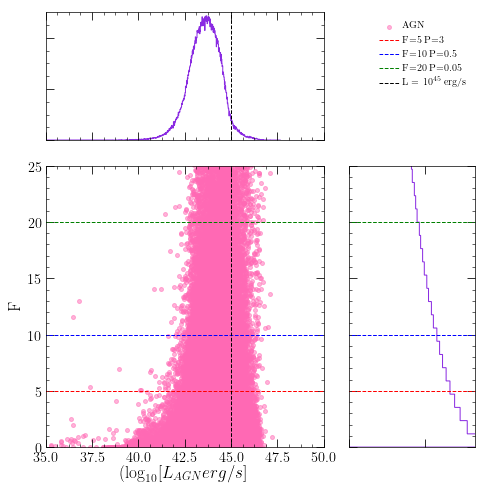

In [8]:
import matplotlib.colors as mcolors



fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)


ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(l0['LAGNerg'],l0['F'],c = 'hotpink',label = 'AGN' ,alpha = 0.5)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'F')
ax.set_xlabel(r'$ (\log_{10}[L_{AGN} erg/s]$')
ax.hlines(5, 0, 50, colors='red', linestyles='dashed', label='F=5 P=3%')
ax.hlines(10, 0, 50, colors='blue', linestyles='dashed', label='F=10 P=0.5%')
ax.hlines(20, 0, 50, colors='green', linestyles='dashed', label='F=20 P=0.05%')
ax.vlines(45, 0, 400, colors='black', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.set_xlim(35, 50)
ax.set_ylim(0,25)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(l0['LAGNerg'], bins=1000, histtype='step', color='blueviolet', density=True, lw=1, label="x")
ax.vlines(45, 0, 400, colors='black', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(35, 50)
ax.set_ylim(0,0.5)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(l0['F'], bins=1000,orientation='horizontal', histtype='step', color='blueviolet', density=False, lw=1, label="y", log = True)
ax.hlines(5, 0, 10**5, colors='red', linestyles='dashed', label='F=5 P=3%')
ax.hlines(10, 0, 10**5, colors='blue', linestyles='dashed', label='F=10 P=0.5%')
ax.hlines(20, 0, 10**5, colors='green', linestyles='dashed', label='F=20 P=0.05%')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(0,25)
ax.set_xlim(10**0,10**5)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)



Text(0, 0.5, 'Frequency')

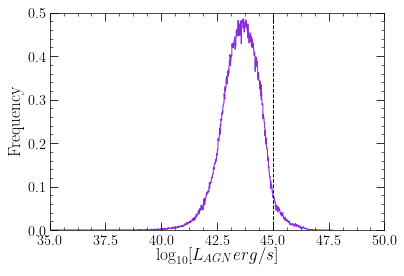

In [9]:
plt.hist(l0['LAGNerg'], bins=1000, histtype='step', color='blueviolet', density=True, lw=1, label="x")
plt.vlines(45, 0, 400, colors='black', linestyles='dashed', label='L = $10^{45}$ erg/s')
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top="on", right='on')
plt.xlim(35, 50)
plt.ylim(0,0.5)
plt.xlabel(r'$ \log_{10}[L_{AGN} erg/s]$')
plt.ylabel('Frequency')

In [10]:
#Find Number of AGN in a cut
F = 10
L = 45
AGNinCut = l0[np.logical_and((l0['F'] >= F), (l0['LAGNerg'] >= L))]
print (len(AGNinCut))

print(len(l0['LAGNerg']))

F10 = l0[l0['F']>=10]
print (len(F10))
F5 = l0[l0['F']>=5]
print (len(F5))
F20 = l0[l0['F']>=20]
print (len(F20))

3662
305293
16907
41476
5760


Text(0, 0.5, 'frequency')

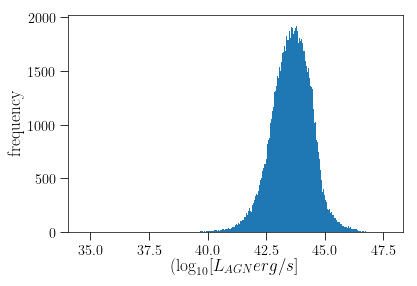

In [11]:
plt.hist(l0['LAGNerg'], 1000)
plt.xlabel(r'$ (\log_{10}[L_{AGN} erg/s]$')
plt.ylabel(r'frequency')




[]

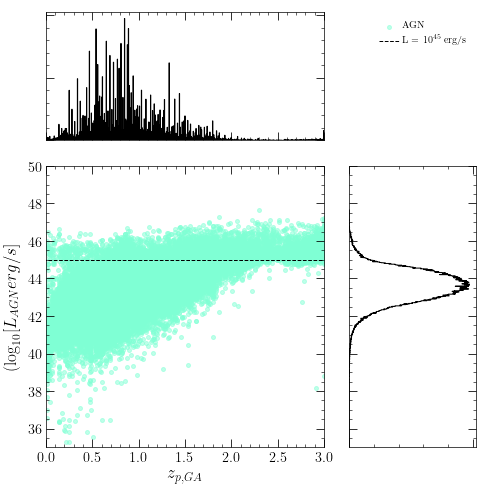

In [12]:
fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)


ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(l0['zGA'],l0['LAGNerg'],c = 'aquamarine',label = 'AGN' ,alpha = 0.5)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlabel(r'$z_{p,GA}$')
ax.set_ylabel(r'$ (\log_{10}[L_{AGN} erg/s]$')
ax.hlines(45, -20, 400, colors='black', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.set_ylim(35, 50)
ax.set_xlim(0,3)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(l0['zGA'], bins=1000, histtype='step', color='black', density=True, lw=1, label="x")
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(0, 3)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(l0['LAGNerg'], bins=1000,orientation='horizontal', histtype='step', color='black', density=True, lw=1, label="y")
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(35,50)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)



In [13]:
#selecting cumulative number of AGN - note you can't just use no. AGN at given intensity because they are precise 'I' values


I1 = np.array(l0['Imag'])
I = sorted(I1, reverse=False)
I = MaskedColumn(name = "I", data = sorted(I1, reverse=False)  , dtype=np.float64)
l0.add_column(I)
#l0.replace_column('I',I )
print(len(I))


#adding indexing
index = np.linspace(1,305293,305293)
index = MaskedColumn(name = "index", data = np.linspace(1,305293,305293)  , dtype=np.float64)
l0.add_column(index)
#l0.replace_column('index',index )


#for SA
SA = MaskedColumn(name = "SA", data = [i/8.54 for i in l0['index']]  , dtype=np.float64)
l0.add_column(SA)
#l0.replace_column('SA',SA )

#splitting by F-ratio as in Figure 17

F10 = l0[l0['F']>=10]
I1 = np.array(F10['Imag'])
I10 = sorted(I1, reverse=False)
L1 = np.array(F10['LAGNerg'])
L10 = sorted(L1, reverse=False)
SA10 = [i/8.54 for i in F10['index']]
F5 = l0[l0['F']>=5]
I1 = np.array(F5['Imag'])
I5 = sorted(I1, reverse=False)
L1 = np.array(F5['LAGNerg'])
L5 = sorted(L1, reverse=False)
SA5 = [i/8.54 for i in F5['index']]
F20 = l0[l0['F']>=20]
I1 = np.array(F20['Imag'])
I20 = sorted(I1, reverse=False)
L1 = np.array(F20['LAGNerg'])
L20 = sorted(L1, reverse=False)
SA20 = [i/8.54 for i in F20['index']]

print (len(L10))
print (len(L5))
print (len(L20))



305293
16907
41476
5760


Text(0, 0.5, 'N')

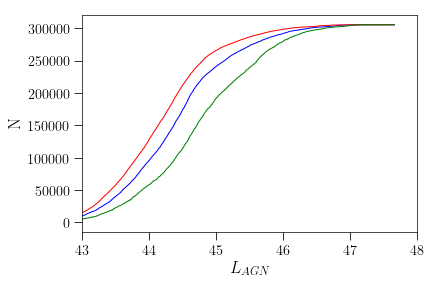

In [14]:
plt.xlim(43,48)
#plt.ylim(0,50000)
plt.plot(L10,F10['index'], c = 'b')
plt.plot(L5,F5['index'],c = 'r' )
plt.plot(L20,F20['index'], c = 'g')
plt.xlabel(r'$L_{AGN}$')
plt.ylabel(r'N')


Text(0, 0.5, 'AGN Surface Density')

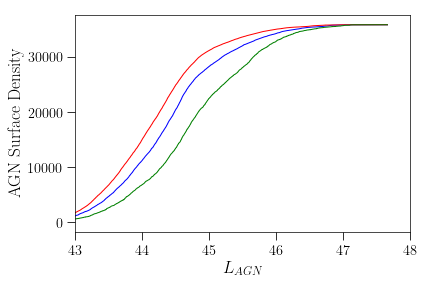

In [15]:
plt.xlim(43,48)
#plt.ylim(15,25)
plt.plot(L10,SA10, c = 'b')
plt.plot(L5,SA5,c = 'r' )
plt.plot(L20,SA20, c = 'g')
plt.xlabel(r'$L_{AGN}$')
plt.ylabel(r'AGN Surface Density')

In [16]:
#need to sum the galaxy luminosity so change to log ergs then unlog and add then re log
#the change from l0 to lg0 is removing the sample that have l = 0 from lg as well 
#check the numbers in sample for lg0 with the numbers for l0 as this mught affect size of cut? though maybe ignore lg0?
#note by limiting samplee not only by non zero Lagn but also by non zero Lg's we are reducing the number of data points, potentially significantly
#lets check by how much..
# cuts it down considerably I wonder if it would be better to keep if not all of them are 0 just not add the zero  though is that not what i did before?
#careful with when i re-run this box because the orignal won't run without taking the 3's back out 
#find and replace all the 0's with a number far larger than real then after adding make a range cut to take them out ?


LSbcerg = MaskedColumn(name = "LSbcerg", data = ((l0['LSbc'])+43.58) , dtype=np.float64) # 44 or 43?
l0.add_column(LSbcerg)
#l0.replace_column('LSbcerg',LSbcerg)

LEllerg = MaskedColumn(name = "LEllerg", data = ((l0['LEll'])+43.58) , dtype=np.float64) # 44 or 43?
l0.add_column(LEllerg)
#l0.replace_column('LEllerg',LEllerg)

LIrrerg = MaskedColumn(name = "LIrrerg", data = ((l0['LIrr'])+43.58) , dtype=np.float64) # 44 or 43?
l0.add_column(LIrrerg)
#l0.replace_column('LIrrerg',LIrrerg)


Lg = MaskedColumn(name = "Lg", data = list(map(sum, zip(10**(l0['LEllerg']),10**(l0['LSbcerg']),10**(l0['LIrrerg']))))  , dtype=np.float64)
l0.add_column(Lg)
#l0.replace_column('Lg',Lg )

LGlog =  MaskedColumn(name = "LGlog", data = np.log10(l0['Lg']) , dtype=np.float64) 
l0.add_column(LGlog)
#l0.replace_column('LGlog',LGlog)


F10 = l0[l0['F']>=10]
I1 = np.array(F10['Imag'])
I10 = sorted(I1, reverse=False)
L1 = np.array(F10['LAGNerg'])
L10 = sorted(L1, reverse=False)
SA10 = [i/8.54 for i in F10['index']]
F5 = l0[l0['F']>=5]
I1 = np.array(F5['Imag'])
I5 = sorted(I1, reverse=False)
L1 = np.array(F5['LAGNerg'])
L5 = sorted(L1, reverse=False)
SA5 = [i/8.54 for i in F5['index']]
F20 = l0[l0['F']>=20]
I1 = np.array(F20['Imag'])
I20 = sorted(I1, reverse=False)
L1 = np.array(F20['LAGNerg'])
L20 = sorted(L1, reverse=False)
SA20 = [i/8.54 for i in F20['index']]

print (len(l0['LAGNerg']))
print (len(F5['LAGNerg']))
print (len(F10['LAGNerg']))
print (len(F20['LAGNerg']))

305293
41476
16907
5760


In [17]:
l0

<Table length=305293>
  RAdeg    DEdeg     Imag  ...           Lg                 LGlog       
 float64  float64  float64 ...        float64              float64      
--------- -------- ------- ... ---------------------- ------------------
217.18223 32.30523   22.77 ...  3.817644801226373e+44  44.58179551859838
217.86705 32.30527   20.02 ... 2.3006694855720697e+44  44.36185423235735
217.88212 32.30531   22.67 ... 1.2627213821635071e+44  44.10130753461119
217.84705 32.30564   20.44 ... 1.4330798561868888e+45  45.15627039146854
217.70446 32.30566   19.34 ...  6.189801213574065e+43 43.791676701809436
217.48821 32.30604   19.71 ...   2.00874071944412e+44 44.302923883297964
217.36268  32.3061   18.71 ... 1.2536997181064061e+44 44.098193528212455
217.24316 32.30626   22.34 ...  2.004170245820466e+44   44.3019346102491
217.16662 32.30637   21.26 ...  2.051598066254645e+44  44.31209228104719
217.27482  32.3064   19.08 ...  7.751019176654467e+43  43.88935881137028
      ...      ...     ... ...                    ...                ...
217.46691 35.83682   22.42 ...  7.235108454385459e+43  43.85944504558472
216.45736 35.83683   22.78 ... 1.3505119754391339e+45  45.13049843957425
 217.3773 35.83683   20.35 ...  5.975696946828561e+44  44.77638856443362
218.31186 35.83712   21.96 ...  7.086315226936815e+43   43.8504204675391
216.59854 35.83722   20.38 ... 1.6339879065119349e+44 44.213248837903514
216.62134  35.8374   20.51 ...  2.143801195631517e+45  45.33118450879899
218.37061 35.83753   22.02 ... 1.9522122490066677e+44   44.2905270333928
216.61578 35.83764   21.39 ...  9.093265441636474e+43  43.95871986876851
216.26838 35.83767   21.15 ...  4.139639856489176e+44  44.61696255968541
216.17744 35.83784   22.95 ... 3.2439784310079017e+44  44.51107795795423

[]

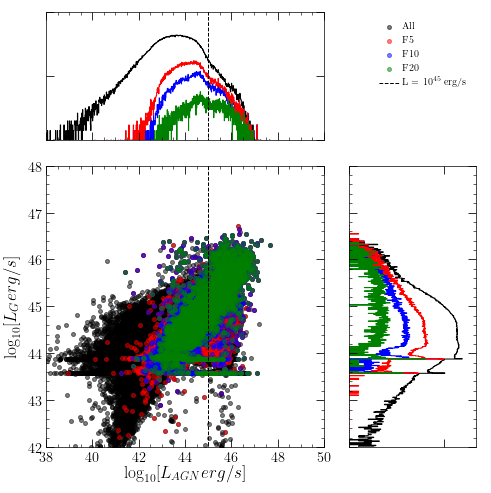

In [18]:
fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)


ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(l0['LAGNerg'],l0['LGlog'],c = 'black',label = 'All' ,alpha = 0.5)
ax.scatter(F5['LAGNerg'],F5['LGlog'],c = 'red',label = 'F5' ,alpha = 0.5)
ax.scatter(F10['LAGNerg'],F10['LGlog'],c = 'blue',label = 'F10' ,alpha = 0.5)
ax.scatter(F20['LAGNerg'],F20['LGlog'],c = 'green',label = 'F20' ,alpha = 0.5)
ax.vlines(45, -20, 10**4, colors='black', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$ \log_{10}[L_{G} erg/s]$')
ax.set_xlabel(r'$ \log_{10}[L_{AGN} erg/s]$')
ax.set_xlim(38, 50)
ax.set_ylim(42,48)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(l0['LAGNerg'], bins=1000, histtype='step', color='black', density=False, lw=1, label="x", log=True)
ax.hist(F10['LAGNerg'], bins=1000, histtype='step', color='blue', density=False, lw=1, label="x", log=True)
ax.hist(F5['LAGNerg'], bins=1000, histtype='step', color='red', density=False, lw=1, label="x", log=True)
ax.hist(F20['LAGNerg'], bins=1000, histtype='step', color='green', density=False, lw=1, label="x", log=True)
ax.vlines(45, -20, 10**4, colors='black', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(38, 50)
ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(l0['LGlog'], bins=1000,orientation='horizontal', histtype='step', color='black', density=False, lw=1, label="y", log=True)
ax.hist(F10['LGlog'], bins=1000,orientation='horizontal', histtype='step', color='blue', density=False, lw=1, label="y", log=True)
ax.hist(F5['LGlog'], bins=1000,orientation='horizontal', histtype='step', color='red', density=False, lw=1, label="y", log=True)
ax.hist(F20['LGlog'], bins=1000,orientation='horizontal', histtype='step', color='green', density=False, lw=1, label="y", log=True)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(42,48)
ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)



In [19]:
l01 = l0[l0['LSbc']!=0.0]
l02 = l01[l01['LEll']!=0.0]
l03 = l02[l02['LIrr']!=0.0]


#add columns correcting units- so then all 0.0 's are  43.58
#add columns unlogging 
#thennn add columns replacing 43.58 with 0
#then add lg column (sum them)
#then add log column 


LSbcerg = MaskedColumn(name = "LSbcerg", data = ((l03['LSbc'])+43.58) , dtype=np.float64) # 44 or 43?
#l03.add_column(LSbcerg)
l03.replace_column('LSbcerg',LSbcerg)

LEllerg = MaskedColumn(name = "LEllerg", data = ((l03['LEll'])+43.58) , dtype=np.float64) # 44 or 43?
#l03.add_column(LEllerg)
l03.replace_column('LEllerg',LEllerg)

LIrrerg = MaskedColumn(name = "LIrrerg", data = ((l03['LIrr'])+43.58) , dtype=np.float64) # 44 or 43?
#l03.add_column(LIrrerg)
l03.replace_column('LIrrerg',LIrrerg)


Lg = MaskedColumn(name = "Lg", data = list(map(sum, zip(10**(l03['LEllerg']),10**(l03['LSbcerg']),10**(l03['LIrrerg']))))  , dtype=np.float64)
#l03.add_column(Lg)
l03.replace_column('Lg',Lg )

LGlog =  MaskedColumn(name = "LGlog", data = np.log10(l03['Lg']) , dtype=np.float64) 
#l03.add_column(LGlog)
l03.replace_column('LGlog',LGlog)


F103 = l03[l03['F']>=10]
I13 = np.array(F103['Imag'])
I103 = sorted(I13, reverse=False)
L13 = np.array(F103['LAGNerg'])
L103 = sorted(L13, reverse=False)
SA103 = [i/8.54 for i in F103['index']]
F53 = l03[l03['F']>=5]
I13 = np.array(F53['Imag'])
I53 = sorted(I13, reverse=False)
L13 = np.array(F53['LAGNerg'])
L53 = sorted(L13, reverse=False)
SA53 = [i/8.54 for i in F53['index']]
F203 = l03[l03['F']>=20]
I13 = np.array(F203['Imag'])
I203 = sorted(I13, reverse=False)
L13 = np.array(F203['LAGNerg'])
L203 = sorted(L13, reverse=False)
SA203 = [i/8.54 for i in F203['index']]

print (len(l03['LAGNerg']))
print (len(F53['LAGNerg']))
print (len(F103['LAGNerg']))
print (len(F203['LAGNerg']))

56026
1243
334
79


[]

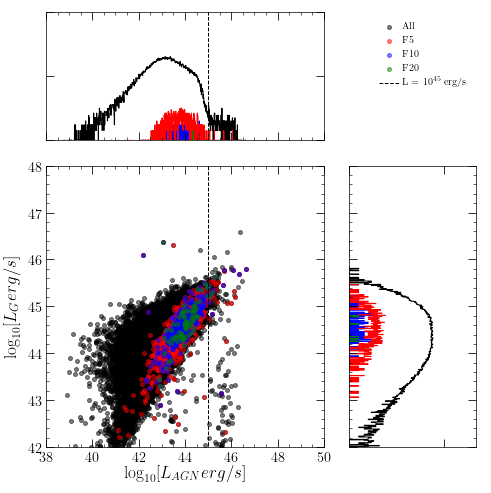

In [20]:
fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)


ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(l03['LAGNerg'],l03['LGlog'],c = 'black',label = 'All' ,alpha = 0.5)
ax.scatter(F53['LAGNerg'],F53['LGlog'],c = 'red',label = 'F5' ,alpha = 0.5)
ax.scatter(F103['LAGNerg'],F103['LGlog'],c = 'blue',label = 'F10' ,alpha = 0.5)
ax.scatter(F203['LAGNerg'],F203['LGlog'],c = 'green',label = 'F20' ,alpha = 0.5)
ax.vlines(45, -20, 10**4, colors='black', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$ \log_{10}[L_{G} erg/s]$')
ax.set_xlabel(r'$ \log_{10}[L_{AGN} erg/s]$')
ax.set_xlim(38, 50)
ax.set_ylim(42,48)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(l03['LAGNerg'], bins=1000, histtype='step', color='black', density=False, lw=1, label="x", log=True)
ax.hist(F103['LAGNerg'], bins=1000, histtype='step', color='blue', density=False, lw=1, label="x", log=True)
ax.hist(F53['LAGNerg'], bins=1000, histtype='step', color='red', density=False, lw=1, label="x", log=True)
ax.hist(F203['LAGNerg'], bins=1000, histtype='step', color='green', density=False, lw=1, label="x", log=True)
ax.vlines(45, -20, 10**4, colors='black', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(38, 50)
ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(l03['LGlog'], bins=1000,orientation='horizontal', histtype='step', color='black', density=False, lw=1, label="y", log=True)
ax.hist(F103['LGlog'], bins=1000,orientation='horizontal', histtype='step', color='blue', density=False, lw=1, label="y", log=True)
ax.hist(F53['LGlog'], bins=1000,orientation='horizontal', histtype='step', color='red', density=False, lw=1, label="y", log=True)
ax.hist(F203['LGlog'], bins=1000,orientation='horizontal', histtype='step', color='green', density=False, lw=1, label="y", log=True)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(42,48)
ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)



In [21]:
#add columns unlogging 
LSbc1 = MaskedColumn(name = "LSbc1", data = (10**(l0['LSbcerg'])) , dtype=np.float64) 
l0.add_column(LSbc1)
#l0.replace_column('LSbc1',LSbc1)

LEll1 = MaskedColumn(name = "LEll1", data = (10**(l0['LEllerg'])) , dtype=np.float64) 
l0.add_column(LEll1)
#l0.replace_column('LEll1',LEll1)

LIrr1 = MaskedColumn(name = "LIrr1", data = (10**(l0['LIrrerg'])) , dtype=np.float64) 
l0.add_column(LIrr1)
#l0.replace_column('LIrr1',LIrr1)



In [22]:
LSbc2 = MaskedColumn(name = "LSbc2", data = (np.where(l0['LSbc1']==10**43.58,0, l0['LSbc1'])) , dtype=np.float64) 
l0.add_column(LSbc2)
#l0.replace_column('LSbc2',LSbc2)

print (l0['LSbc2'])

        LSbc2         
----------------------
2.5644840365177108e+44
1.1220184543019561e+44
                   0.0
 7.925013304804734e+44
3.9264493539960094e+42
  1.04712854805089e+42
 6.998419960022716e+42
 1.333521432163324e+42
                   0.0
1.4723125024327162e+42
                   ...
                   0.0
1.3001695780332818e+43
 1.230268770812371e+45
2.1281390459826916e+44
                   0.0
2.0183663636815597e+43
 1.811340092619584e+45
1.1561122421920863e+44
2.9308932452503126e+43
2.2803420720004023e+44
 2.477422057633276e+44
Length = 305293 rows


In [23]:
#This won't work if all values are 0 will give an 'undefined value'

#add columns correcting units- so then all 0.0 's are  43.58





#add columns unlogging 
LSbc1 = MaskedColumn(name = "LSbc1", data = (10**(l0['LSbcerg'])) , dtype=np.float64) 
#l0.add_column(LSbc1)
l0.replace_column('LSbc1',LSbc1)

LEll1 = MaskedColumn(name = "LEll1", data = (10**(l0['LEllerg'])) , dtype=np.float64) 
#l0.add_column(LEll1)
l0.replace_column('LEll1',LEll1)

LIrr1 = MaskedColumn(name = "LIrr1", data = (10**(l0['LIrrerg'])) , dtype=np.float64) 
#l0.add_column(LIrr1)
l0.replace_column('LIrr1',LIrr1)



#thennn add columns replacing 43.58 with 0
LSbc2 = MaskedColumn(name = "LSbc2", data = (np.where(l0['LSbc1']==10**43.58,0, l0['LSbc1'])) , dtype=np.float64) 
#l0.add_column(LSbc2)
l0.replace_column('LSbc2',LSbc2)

LEll2 = MaskedColumn(name = "LEll2", data = (np.where(l0['LEll1']==10**43.58,0, l0['LEll1'])) , dtype=np.float64) 
l0.add_column(LEll2)
#l0.replace_column('LEll2',LEll2)

LIrr2 = MaskedColumn(name = "LIrr2", data = (np.where(l0['LIrr1']==10**43.58,0, l0['LIrr1'])) , dtype=np.float64) 
l0.add_column(LIrr2)
#l0.replace_column('LIrr2',LIrr2)

#then add lg column (sum them)
Lg = MaskedColumn(name = "Lg", data = list(map(sum, zip(l0['LEll2'],l0['LSbc2'],l0['LIrr2'])))  , dtype=np.float64)
#l0.add_column(Lg)
l0.replace_column('Lg',Lg )



#then add log column 
LGlog =  MaskedColumn(name = "LGlog", data = np.log10(l0['Lg']) , dtype=np.float64) 
#l0.add_column(LGlog)
l0.replace_column('LGlog',LGlog)

#remove the values where they are all 0
lg0 = l0[[np.isfinite(l0['LGlog'])]]

F10 = lg0[lg0['F']>=10]
I1 = np.array(F10['Imag'])
I10 = sorted(I1, reverse=False)
L1 = np.array(F10['LAGNerg'])
L10 = sorted(L1, reverse=False)
SA10 = [i/8.54 for i in F10['index']]
F5 = lg0[lg0['F']>=5]
I1 = np.array(F5['Imag'])
I5 = sorted(I1, reverse=False)
L1 = np.array(F5['LAGNerg'])
L5 = sorted(L1, reverse=False)
SA5 = [i/8.54 for i in F5['index']]
F20 = lg0[lg0['F']>=20]
I1 = np.array(F20['Imag'])
I203 = sorted(I1, reverse=False)
L1 = np.array(F20['LAGNerg'])
L20 = sorted(L1, reverse=False)
SA20 = [i/8.54 for i in F20['index']]

print (len(lg0['LAGNerg']))
print (len(F5['LAGNerg']))
print (len(F10['LAGNerg']))
print (len(F20['LAGNerg']))

305254
41470
16907
5760


In [24]:
lg0

<Table length=305254>
  RAdeg    DEdeg     Imag  ...         LEll2                  LIrr2         
 float64  float64  float64 ...        float64                float64        
--------- -------- ------- ... ---------------------- ----------------------
217.18223 32.30523   22.77 ...                    0.0  8.729713683881023e+43
217.86705 32.30527   20.02 ... 1.0471285480508899e+44 1.3152248321922376e+43
217.88212 32.30531   22.67 ...                    0.0  5.023425895223877e+43
217.84705 32.30564   20.44 ...                    0.0  6.025595860743593e+44
217.70446 32.30566   19.34 ... 1.9952623149688666e+43                    0.0
217.48821 32.30604   19.71 ...                    0.0 1.6180800376430512e+44
217.36268  32.3061   18.71 ...                    0.0  8.035261221856194e+43
217.24316 32.30626   22.34 ...                    0.0 1.6106456351782731e+44
217.16662 32.30637   21.26 ...                    0.0 1.2912192736135256e+44
217.27482  32.3064   19.08 ...                    0.0                    0.0
      ...      ...     ... ...                    ...                    ...
217.46691 35.83682   22.42 ...                    0.0 2.1330449131465794e+43
216.45736 35.83683   22.78 ...                    0.0  8.222426499470696e+43
 217.3773 35.83683   20.35 ... 3.4673685045253094e+44                    0.0
218.31186 35.83712   21.96 ...  8.689604292863019e+42  2.415460834444916e+43
216.59854 35.83722   20.38 ...                    0.0  1.051961873823219e+44
216.62134  35.8374   20.51 ...                    0.0 2.9444216337987695e+44
218.37061 35.83753   22.02 ...                    0.0 4.1591061049402186e+43
216.61578 35.83764   21.39 ... 2.3604782331805637e+43                    0.0
216.26838 35.83767   21.15 ... 1.4791083881682133e+44                    0.0
216.17744 35.83784   22.95 ...                    0.0  3.863669770540658e+43

[]

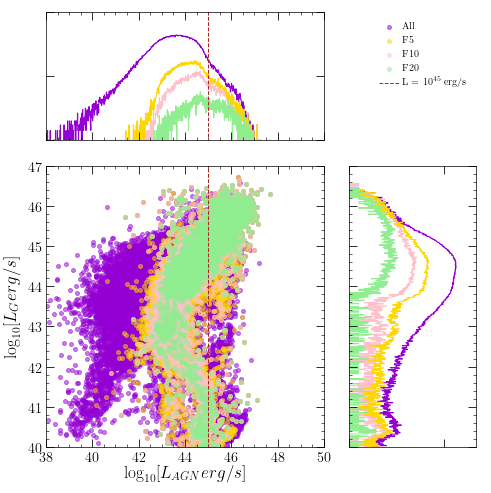

In [25]:
fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)


ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(lg0['LAGNerg'],lg0['LGlog'],c = 'darkviolet',label = 'All' ,alpha = 0.5)
ax.scatter(F5['LAGNerg'],F5['LGlog'],c = 'gold',label = 'F5' ,alpha = 0.5)
ax.scatter(F10['LAGNerg'],F10['LGlog'],c = 'pink',label = 'F10' ,alpha = 0.5)
ax.scatter(F20['LAGNerg'],F20['LGlog'],c = 'lightgreen',label = 'F20' ,alpha = 0.5)
ax.vlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$ \log_{10}[L_{G} erg/s]$')
ax.set_xlabel(r'$ \log_{10}[L_{AGN} erg/s]$')
ax.set_xlim(38, 50)
ax.set_ylim(40,47)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(lg0['LAGNerg'], bins=1000, histtype='step', color='darkviolet', density=False, lw=1, label="x", log=True)
ax.hist(F10['LAGNerg'], bins=1000, histtype='step', color='pink', density=False, lw=1, label="x", log=True)
ax.hist(F5['LAGNerg'], bins=1000, histtype='step', color='gold', density=False, lw=1, label="x", log=True)
ax.hist(F20['LAGNerg'], bins=1000, histtype='step', color='lightgreen', density=False, lw=1, label="x", log=True)
ax.vlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(38, 50)
ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(lg0['LGlog'], bins=1000,orientation='horizontal', histtype='step', color='darkviolet', density=False, lw=1, label="y", log=True)
ax.hist(F10['LGlog'], bins=1000,orientation='horizontal', histtype='step', color='pink', density=False, lw=1, label="y", log=True)
ax.hist(F5['LGlog'], bins=1000,orientation='horizontal', histtype='step', color='gold', density=False, lw=1, label="y", log=True)
ax.hist(F20['LGlog'], bins=1000,orientation='horizontal', histtype='step', color='lightgreen', density=False, lw=1, label="y", log=True)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(40,47)
ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)



(1, 10000)

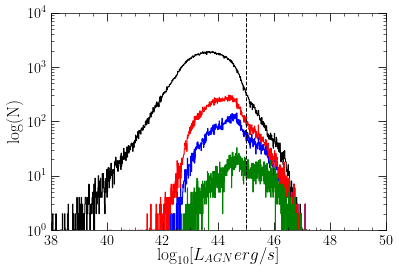

In [26]:
plt.hist(lg0['LAGNerg'], bins=1000, histtype='step', color='black', density=False, lw=1, label="x", log=True)
plt.hist(F10['LAGNerg'], bins=1000, histtype='step', color='blue', density=False, lw=1, label="x", log=True)
plt.hist(F5['LAGNerg'], bins=1000, histtype='step', color='red', density=False, lw=1, label="x", log=True)
plt.hist(F20['LAGNerg'], bins=1000, histtype='step', color='green', density=False, lw=1, label="x", log=True)
plt.vlines(45, -20, 10**4, colors='black', linestyles='dashed', label='L = $10^{45}$ erg/s')
plt.xlabel(r'$ \log_{10}[L_{AGN} erg/s]$')
plt.ylabel(r'log(N)')
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top="on", right='on')
plt.xlim(38, 50)
plt.ylim(10**0,10**4)

(0, 300)

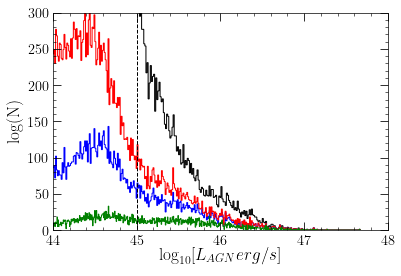

In [27]:
plt.hist(lg0['LAGNerg'], bins=1000, histtype='step', color='black', density=False, lw=1, label="x")
plt.hist(F10['LAGNerg'], bins=1000, histtype='step', color='blue', density=False, lw=1, label="x")
plt.hist(F5['LAGNerg'], bins=1000, histtype='step', color='red', density=False, lw=1, label="x")
plt.hist(F20['LAGNerg'], bins=1000, histtype='step', color='green', density=False, lw=1, label="x")
plt.vlines(45, -20, 10**4, colors='black', linestyles='dashed', label='L = $10^{45}$ erg/s')
plt.xlabel(r'$ \log_{10}[L_{AGN} erg/s]$')
plt.ylabel(r'log(N)')
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top="on", right='on')
plt.xlim(44, 48)
plt.ylim(0,300)


(1, 10000)

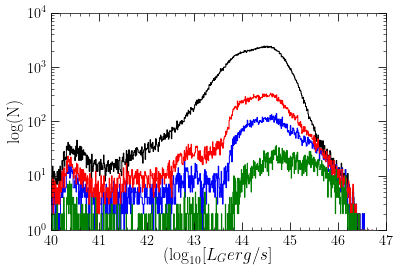

In [28]:
plt.hist(lg0['LGlog'], bins=1000, histtype='step', color='black', density=False, lw=1, label="y", log=True)
plt.hist(F10['LGlog'], bins=1000, histtype='step', color='blue', density=False, lw=1, label="y", log=True)
plt.hist(F5['LGlog'], bins=1000, histtype='step', color='red', density=False, lw=1, label="y", log=True)
plt.hist(F20['LGlog'], bins=1000, histtype='step', color='green', density=False, lw=1, label="y", log=True)
plt.xlabel(r'$ (\log_{10}[L_{G} erg/s]$')
plt.ylabel(r'log(N)')
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top="on", right='on')
plt.xlim(40,47)
plt.ylim(10**0,10**4)

(0, 300)

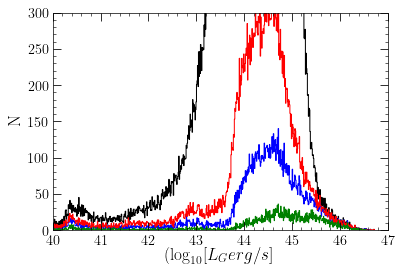

In [29]:
plt.hist(lg0['LGlog'], bins=1000, histtype='step', color='black', density=False, lw=1, label="y")
plt.hist(F10['LGlog'], bins=1000, histtype='step', color='blue', density=False, lw=1, label="y")
plt.hist(F5['LGlog'], bins=1000, histtype='step', color='red', density=False, lw=1, label="y")
plt.hist(F20['LGlog'], bins=1000, histtype='step', color='green', density=False, lw=1, label="y")
plt.xlabel(r'$ (\log_{10}[L_{G} erg/s]$')
plt.ylabel(r'N')
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top="on", right='on')
plt.xlim(40,47)
plt.ylim(0,300)

In [30]:
#moving onto data set with the data cut by lagn is 45

In [31]:
lg045 = lg0[lg0['LAGNerg']>=45]

In [32]:
len(lg045)

11479

In [33]:
F1045 = lg045[lg045['F']>=10]
F545 = lg045[lg045['F']>=5]
F2045 = lg045[lg045['F']>=20]

[]

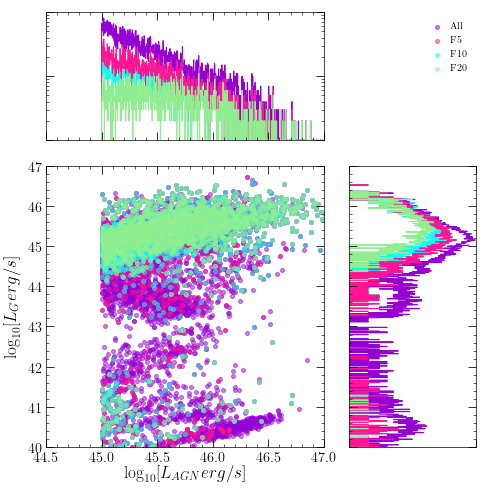

In [34]:
fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)


ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(lg045['LAGNerg'],lg045['LGlog'],c = 'darkviolet',label = 'All' ,alpha = 0.5)
ax.scatter(F545['LAGNerg'],F545['LGlog'],c = 'deeppink',label = 'F5' ,alpha = 0.5)
ax.scatter(F1045['LAGNerg'],F1045['LGlog'],c = 'aqua',label = 'F10' ,alpha = 0.5)
ax.scatter(F2045['LAGNerg'],F2045['LGlog'],c = 'lightgreen',label = 'F20' ,alpha = 0.5)
#ax.vlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$ \log_{10}[L_{G} erg/s]$')
ax.set_xlabel(r'$ \log_{10}[L_{AGN} erg/s]$')
ax.set_xlim(44.5, 47)
ax.set_ylim(40,47)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(lg045['LAGNerg'], bins=1000, histtype='step', color='darkviolet', density=False, lw=1, label="x", log=True)
ax.hist(F1045['LAGNerg'], bins=1000, histtype='step', color='aqua', density=False, lw=1, label="x", log=True)
ax.hist(F545['LAGNerg'], bins=1000, histtype='step', color='deeppink', density=False, lw=1, label="x", log=True)
ax.hist(F2045['LAGNerg'], bins=1000, histtype='step', color='lightgreen', density=False, lw=1, label="x", log=True)
#ax.vlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(44.5, 47)
ax.set_ylim(10**0,10**2)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(lg045['LGlog'], bins=1000,orientation='horizontal', histtype='step', color='darkviolet', density=False, lw=1, label="y", log=True)
ax.hist(F1045['LGlog'], bins=1000,orientation='horizontal', histtype='step', color='aqua', density=False, lw=1, label="y", log=True)
ax.hist(F545['LGlog'], bins=1000,orientation='horizontal', histtype='step', color='deeppink', density=False, lw=1, label="y", log=True)
ax.hist(F2045['LGlog'], bins=1000,orientation='horizontal', histtype='step', color='lightgreen', density=False, lw=1, label="y", log=True)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(40,47)
ax.set_xlim(10**0,10**2)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)



(0, 100)

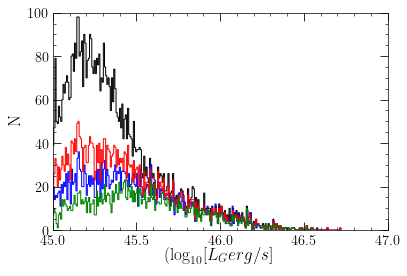

In [35]:
plt.hist(lg045['LGlog'], bins=1000, histtype='step', color='black', density=False, lw=1, label="y")
plt.hist(F1045['LGlog'], bins=1000, histtype='step', color='blue', density=False, lw=1, label="y")
plt.hist(F545['LGlog'], bins=1000, histtype='step', color='red', density=False, lw=1, label="y")
plt.hist(F2045['LGlog'], bins=1000, histtype='step', color='green', density=False, lw=1, label="y")
plt.xlabel(r'$ (\log_{10}[L_{G} erg/s]$')
plt.ylabel(r'N')
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top="on", right='on')
plt.xlim(45,47)
plt.ylim(0,100)

(0, 75)

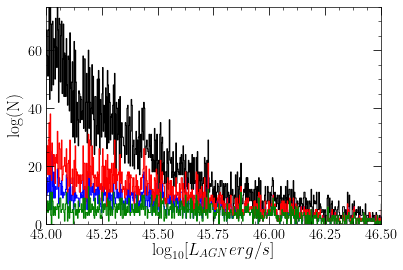

In [36]:
plt.hist(lg045['LAGNerg'], bins=1000, histtype='step', color='black', density=False, lw=1, label="x")
plt.hist(F1045['LAGNerg'], bins=1000, histtype='step', color='blue', density=False, lw=1, label="x")
plt.hist(F545['LAGNerg'], bins=1000, histtype='step', color='red', density=False, lw=1, label="x")
plt.hist(F2045['LAGNerg'], bins=1000, histtype='step', color='green', density=False, lw=1, label="x")
plt.xlabel(r'$ \log_{10}[L_{AGN} erg/s]$')
plt.ylabel(r'log(N)')
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top="on", right='on')
plt.xlim(45, 46.5)
plt.ylim(0,75)

In [37]:
#Find Number of AGN in a cut
F = 10
L = 45
AGNinCut = l0[np.logical_and((l0['F'] >= F), (l0['LAGNerg'] >= L))]
print (len(AGNinCut))

print(len(l0['LAGNerg']))

F10 = l0[l0['F']>=10]
print (len(F10))
F5 = l0[l0['F']>=5]
print (len(F5))
F20 = l0[l0['F']>=20]
print (len(F20))

3662
305293
16907
41476
5760


In [38]:
from scipy.stats import f

F = np.linspace(0,50,101)
#F = [5,10,20]  # use specfic values to print the value below 

N = []
for i in F:
    N.append(len(l0[l0['F']>= i]))


N45 = []
for i in F:
    N45.append(len(lg045[lg045['F']>= i]))

    
#dfn, dfd = 2, 9
#vals = f.ppf([0.001, 0.995, 0.999], dfn, dfd)
#print (vals)    
    
#defining degrees of freedom in f-test
dfn, dfd = 2, 9
Prob = f.cdf(F, dfn, dfd)

P = np.subtract(1,Prob)
spurious = np.multiply(N45,P)
nospurious = np.subtract(N45,spurious)
spuriousfrac = np.divide(spurious, N45)

#print ("F-value =", F)
#print ("Probality =", P)
print ("Number in sample with L>10^45 =", N45)
#print ("Number of spurious in sample =", spurious)
#print ("Fraction of spurious in sample =", spuriousfrac)
#print ("Number of none spurious in sample =", nospurious)


Number in sample with L>10^45 = [11479, 10358, 9429, 8589, 7959, 7359, 6806, 6332, 5924, 5620, 5348, 5122, 4910, 4680, 4504, 4330, 4158, 4023, 3901, 3786, 3662, 3567, 3464, 3385, 3292, 3218, 3120, 3053, 2982, 2910, 2835, 2767, 2704, 2643, 2584, 2538, 2494, 2449, 2402, 2367, 2332, 2296, 2258, 2225, 2188, 2149, 2112, 2075, 2048, 2012, 1984, 1954, 1924, 1900, 1881, 1856, 1825, 1796, 1770, 1741, 1718, 1697, 1677, 1643, 1618, 1594, 1572, 1552, 1527, 1504, 1485, 1462, 1435, 1423, 1407, 1379, 1353, 1335, 1311, 1294, 1280, 1263, 1245, 1227, 1206, 1191, 1181, 1166, 1145, 1126, 1116, 1094, 1080, 1066, 1050, 1037, 1023, 1016, 1008, 996, 982]


In [39]:
new_table = Table([F, P, N45, spurious, spuriousfrac, nospurious])
from astropy.io import ascii
ascii.write(new_table, 'new_table.fits', names=['F', 'P', 'N45', 'spurious', 'spuriousfrac', 'nospurious'], overwrite=True)

In [40]:
new_table.rename_column('col0', 'F')  
new_table.rename_column('col1', 'P') 
new_table.rename_column('col2', 'N45')  
new_table.rename_column('col3', 'spurious') 
new_table.rename_column('col4', 'spuriousfrac')  
new_table.rename_column('col5', 'nospurious')  


In [41]:
new_table.show_in_browser(jsviewer=True)  


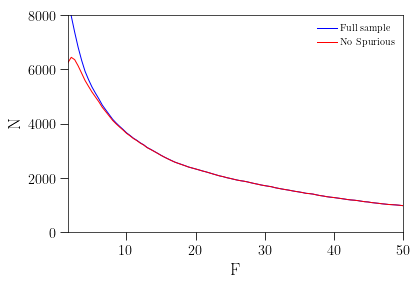

In [42]:
plt.plot(F,N45, color = 'blue', label = 'Full sample')
plt.plot(F,nospurious, color = 'red', label = 'No Spurious')
plt.xlabel('F')
plt.ylabel('N')
plt.xlim(1.5,50)
plt.ylim(0,8000)
plt.legend()


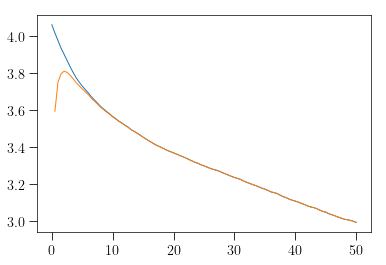

In [43]:
plt.plot(F,np.log10(N45))
plt.plot(F,np.log10(nospurious))
#plt.xlim(2.5,10)
#plt.ylim(3.6,3.8)

(0, 0.01)

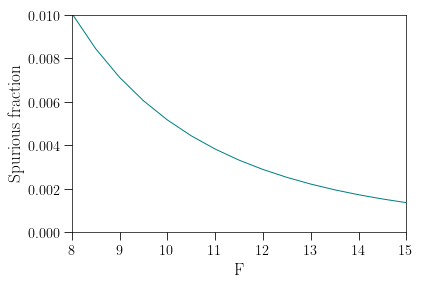

In [44]:
plt.plot(F,spuriousfrac, color = 'teal')
plt.xlabel('F')
plt.ylabel('Spurious fraction')
plt.xlim(8,15)
plt.ylim(0,0.01)


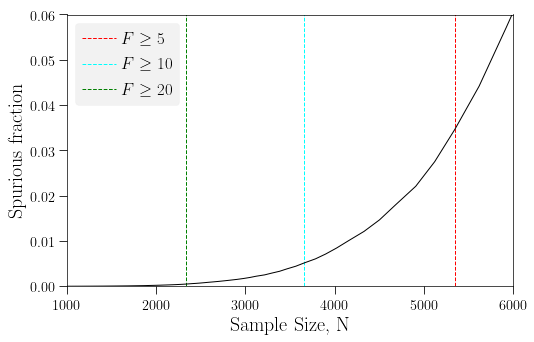

In [80]:
plt.figure(figsize=(8,5))
plt.plot(N45,spuriousfrac, color = 'black')
plt.xlabel('Sample Size, N', fontsize=20)
plt.ylabel('Spurious fraction', fontsize=20)
plt.xlim(1000,6000)
plt.ylim(0,0.06)
plt.vlines(5348, 0, 2, color = 'red', linestyle='--',label = '$F \ge 5$')
plt.vlines(3662, 0, 2, color = 'cyan', linestyle='--',label = '$F \ge 10$')
plt.vlines(2332, 0, 2, color = 'green', linestyle='--',label = '$F \ge 20$')
plt.legend(prop={'size': 17},frameon = True, framealpha=0.1, facecolor = 'gray')
plt.savefig('Figure5.png')



Text(0, 0.5, 'N Spurious')

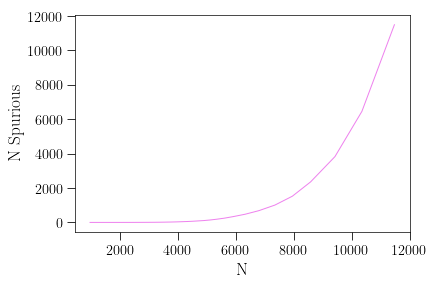

In [46]:
plt.plot(N45,spurious, color = 'violet')
plt.xlabel('N')
plt.ylabel('N Spurious')

 

Text(0, 0.5, '$ \\log_{10}[N Spurious]$')

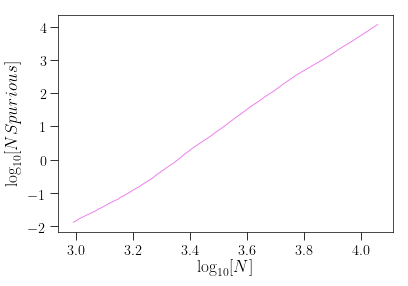

In [47]:

plt.plot(np.log10(N45),np.log10(spurious), color = 'violet')
plt.xlabel(r'$ \log_{10}[N]$')
plt.ylabel(r'$ \log_{10}[N Spurious]$')


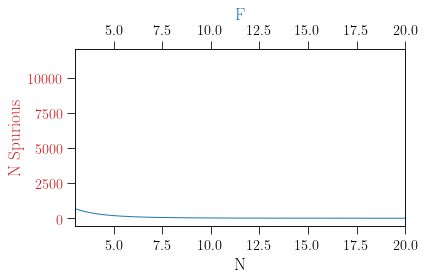

In [48]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('N')
ax1.set_ylabel('N Spurious', color=color)
ax1.plot(N45, spurious, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlim(1000,5500)
ax1.set_xlim(3,20)

ax2 = ax1.twiny()  # instantiate a second axes that shares the same y-axis

color = 'tab:blue'
ax2.set_xlabel('F', color=color)  # we already handled the x-label with ax1
ax2.plot(F, spurious, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_xlim(3,20)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


#nooooooo

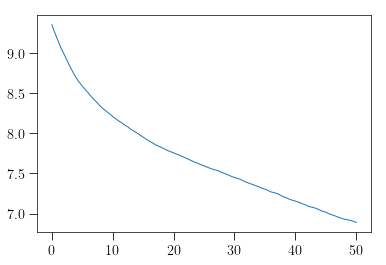

In [49]:
plt.plot(F,np.log(N45))
#there is a relationship between F and N45 its just not linear, so surely could plot on 'same axis' just with different scales, log one?


[]

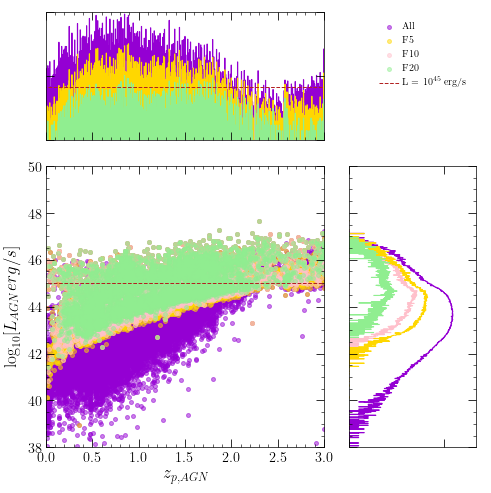

In [50]:



fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)


ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(lg0['zGA'],lg0['LAGNerg'],c = 'darkviolet',label = 'All' ,alpha = 0.5)
ax.scatter(F5['zGA'],F5['LAGNerg'],c = 'gold',label = 'F5' ,alpha = 0.5)
ax.scatter(F10['zGA'],F10['LAGNerg'],c = 'pink',label = 'F10' ,alpha = 0.5)
ax.scatter(F20['zGA'],F20['LAGNerg'],c = 'lightgreen',label = 'F20' ,alpha = 0.5)
ax.hlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$ \log_{10}[L_{AGN} erg/s]$')
ax.set_xlabel(r'$z_{p,AGN}$')
ax.set_xlim(0, 3)
ax.set_ylim(38,50)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(lg0['zGA'], bins=1000, histtype='step', color='darkviolet', density=False, lw=1, label="x", log=True)
ax.hist(F10['zGA'], bins=1000, histtype='step', color='pink', density=False, lw=1, label="x", log=True)
ax.hist(F5['zGA'], bins=1000, histtype='step', color='gold', density=False, lw=1, label="x", log=True)
ax.hist(F20['zGA'], bins=1000, histtype='step', color='lightgreen', density=False, lw=1, label="x", log=True)
ax.hlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(0, 3)
ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(lg0['LAGNerg'], bins=1000,orientation='horizontal', histtype='step', color='darkviolet', density=False, lw=1, label="y", log=True)
ax.hist(F10['LAGNerg'], bins=1000,orientation='horizontal', histtype='step', color='pink', density=False, lw=1, label="y", log=True)
ax.hist(F5['LAGNerg'], bins=1000,orientation='horizontal', histtype='step', color='gold', density=False, lw=1, label="y", log=True)
ax.hist(F20['LAGNerg'], bins=1000,orientation='horizontal', histtype='step', color='lightgreen', density=False, lw=1, label="y", log=True)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(38,50)
ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)



[]

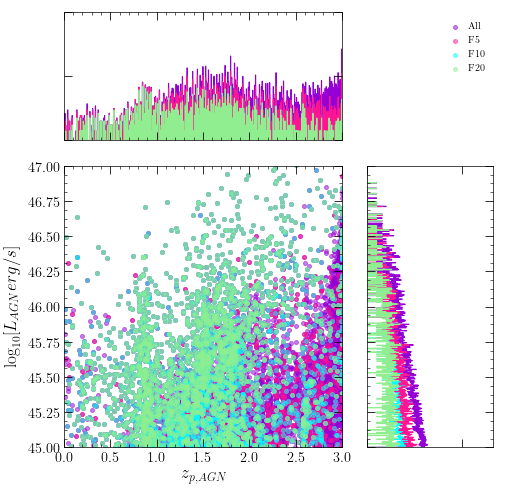

In [51]:
fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)


ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(lg045['zGA'],lg045['LAGNerg'],c = 'darkviolet',label = 'All' ,alpha = 0.5)
ax.scatter(F545['zGA'],F545['LAGNerg'],c = 'deeppink',label = 'F5' ,alpha = 0.5)
ax.scatter(F1045['zGA'],F1045['LAGNerg'],c = 'aqua',label = 'F10' ,alpha = 0.5)
ax.scatter(F2045['zGA'],F2045['LAGNerg'],c = 'lightgreen',label = 'F20' ,alpha = 0.5)
#ax.hlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$ \log_{10}[L_{AGN} erg/s]$')
ax.set_xlabel(r'$z_{p,AGN}$')
ax.set_xlim(0, 3)
ax.set_ylim(45,47)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(lg045['zGA'], bins=1000, histtype='step', color='darkviolet', density=False, lw=1, label="x", log=True)
ax.hist(F1045['zGA'], bins=1000, histtype='step', color='aqua', density=False, lw=1, label="x", log=True)
ax.hist(F545['zGA'], bins=1000, histtype='step', color='deeppink', density=False, lw=1, label="x", log=True)
ax.hist(F2045['zGA'], bins=1000, histtype='step', color='lightgreen', density=False, lw=1, label="x", log=True)
#ax.hlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(0, 3)
ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(lg045['LAGNerg'], bins=1000,orientation='horizontal', histtype='step', color='darkviolet', density=False, lw=1, label="y", log=True)
ax.hist(F1045['LAGNerg'], bins=1000,orientation='horizontal', histtype='step', color='aqua', density=False, lw=1, label="y", log=True)
ax.hist(F545['LAGNerg'], bins=1000,orientation='horizontal', histtype='step', color='deeppink', density=False, lw=1, label="y", log=True)
ax.hist(F2045['LAGNerg'], bins=1000,orientation='horizontal', histtype='step', color='lightgreen', density=False, lw=1, label="y", log=True)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(45,47)
ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)




Text(0, 0.5, '$ (\\log_{10}[L_{AGN} erg/s]$')

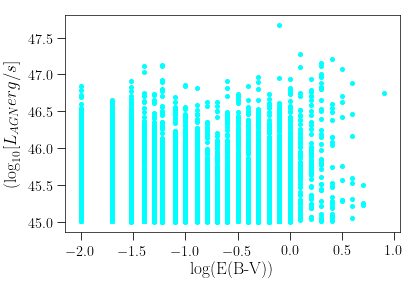

In [52]:
plt.scatter(np.log10(lg045['EBV']),lg045['LAGNerg'], color = 'cyan')
plt.xlabel(r'log(E(B-V))')
plt.ylabel(r'$ (\log_{10}[L_{AGN} erg/s]$')


Text(0, 0.5, '$ (\\log_{10}[L_{AGN} erg/s]$')

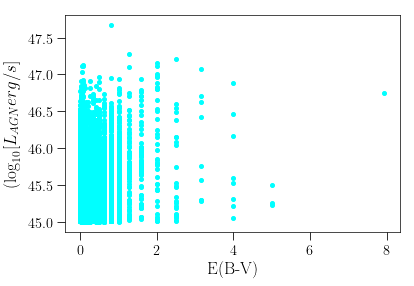

In [53]:
plt.scatter(lg045['EBV'],lg045['LAGNerg'], color = 'cyan')
plt.xlabel(r'E(B-V)')
plt.ylabel(r'$ (\log_{10}[L_{AGN} erg/s]$')


In [54]:
lg045F15 = lg045[lg045['F']>=15]

In [55]:
len(lg045F15)

2835

[]

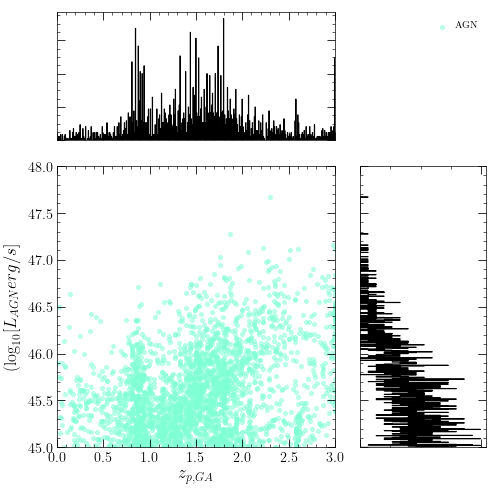

In [56]:
fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)


ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(lg045F15['zGA'],lg045F15['LAGNerg'],c = 'aquamarine',label = 'AGN' ,alpha = 0.5)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlabel(r'$z_{p,GA}$')
ax.set_ylabel(r'$ (\log_{10}[L_{AGN} erg/s]$')
#ax.hlines(45, -20, 400, colors='black', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.set_ylim(45, 48)
ax.set_xlim(0,3)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(lg045F15['zGA'], bins=1000, histtype='step', color='black', density=True, lw=1, label="x")
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(0, 3)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(lg045F15['LAGNerg'], bins=1000,orientation='horizontal', histtype='step', color='black', density=True, lw=1, label="y")
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(45,48)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)



In [57]:
l0Sbc = l0[l0['LSbc']!=0.0]
l0Ell = l0[l0['LEll']!=0.0]
l0Irr = l0[l0['LIrr']!=0.0]

LSbcerg = MaskedColumn(name = "LSbcerg", data = ((l0Sbc['LSbc'])+43.58) , dtype=np.float64) # 44 or 43?
#l0Sbc.add_column(LSbcerg)
l0Sbc.replace_column('LSbcerg',LSbcerg)

LEllerg = MaskedColumn(name = "LEllerg", data = ((l0Ell['LEll'])+43.58) , dtype=np.float64) # 44 or 43?
#l0Ell.add_column(LEllerg)
l0Ell.replace_column('LEllerg',LEllerg)

LIrrerg = MaskedColumn(name = "LIrrerg", data = ((l0Irr['LIrr'])+43.58) , dtype=np.float64) # 44 or 43?
#l0Irr.add_column(LIrrerg)
l0Irr.replace_column('LIrrerg',LIrrerg)



In [58]:
F10Sbc = l0Sbc[l0Sbc['F']>=10]
F5Sbc = l0Sbc[l0Sbc['F']>=5]
F20Sbc = l0Sbc[l0Sbc['F']>=20]

F10Ell = l0Ell[l0Ell['F']>=10]
F5Ell = l0Ell[l0Ell['F']>=5]
F20Ell = l0Ell[l0Ell['F']>=20]

F10Irr = l0Irr[l0Irr['F']>=10]
F5Irr = l0Irr[l0Irr['F']>=5]
F20Irr = l0Irr[l0Irr['F']>=20]


[]

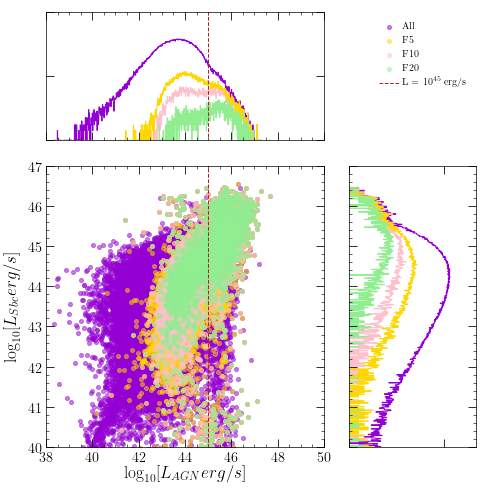

In [59]:
fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)


ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(l0Sbc['LAGNerg'],l0Sbc['LSbcerg'],c = 'darkviolet',label = 'All' ,alpha = 0.5)
ax.scatter(F5Sbc['LAGNerg'],F5Sbc['LSbcerg'],c = 'gold',label = 'F5' ,alpha = 0.5)
ax.scatter(F10Sbc['LAGNerg'],F10Sbc['LSbcerg'],c = 'pink',label = 'F10' ,alpha = 0.5)
ax.scatter(F20Sbc['LAGNerg'],F20Sbc['LSbcerg'],c = 'lightgreen',label = 'F20' ,alpha = 0.5)
ax.vlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$ \log_{10}[L_{Sbc} erg/s]$')
ax.set_xlabel(r'$ \log_{10}[L_{AGN} erg/s]$')
ax.set_xlim(38, 50)
ax.set_ylim(40,47)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(l0Sbc['LAGNerg'], bins=1000, histtype='step', color='darkviolet', density=False, lw=1, label="x", log=True)
ax.hist(F10Sbc['LAGNerg'], bins=1000, histtype='step', color='pink', density=False, lw=1, label="x", log=True)
ax.hist(F5Sbc['LAGNerg'], bins=1000, histtype='step', color='gold', density=False, lw=1, label="x", log=True)
ax.hist(F20Sbc['LAGNerg'], bins=1000, histtype='step', color='lightgreen', density=False, lw=1, label="x", log=True)
ax.vlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(38, 50)
ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(l0Sbc['LSbcerg'], bins=1000,orientation='horizontal', histtype='step', color='darkviolet', density=False, lw=1, label="y", log=True)
ax.hist(F10Sbc['LSbcerg'], bins=1000,orientation='horizontal', histtype='step', color='pink', density=False, lw=1, label="y", log=True)
ax.hist(F5Sbc['LSbcerg'], bins=1000,orientation='horizontal', histtype='step', color='gold', density=False, lw=1, label="y", log=True)
ax.hist(F20Sbc['LSbcerg'], bins=1000,orientation='horizontal', histtype='step', color='lightgreen', density=False, lw=1, label="y", log=True)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(40,47)
ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)



[]

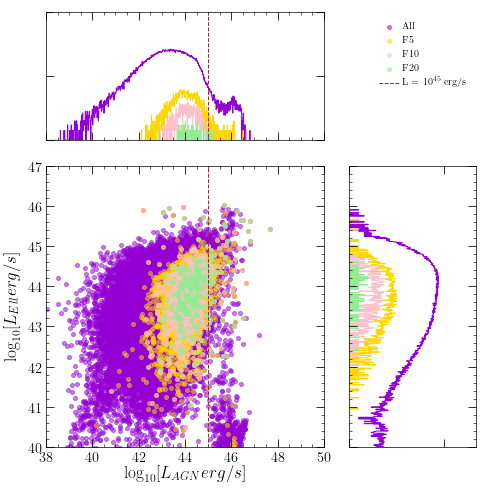

In [60]:
fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)


ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(l0Ell['LAGNerg'],l0Ell['LEllerg'],c = 'darkviolet',label = 'All' ,alpha = 0.5)
ax.scatter(F5Ell['LAGNerg'],F5Ell['LEllerg'],c = 'gold',label = 'F5' ,alpha = 0.5)
ax.scatter(F10Ell['LAGNerg'],F10Ell['LEllerg'],c = 'pink',label = 'F10' ,alpha = 0.5)
ax.scatter(F20Ell['LAGNerg'],F20Ell['LEllerg'],c = 'lightgreen',label = 'F20' ,alpha = 0.5)
ax.vlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$ \log_{10}[L_{Ell} erg/s]$')
ax.set_xlabel(r'$ \log_{10}[L_{AGN} erg/s]$')
ax.set_xlim(38, 50)
ax.set_ylim(40,47)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(l0Ell['LAGNerg'], bins=1000, histtype='step', color='darkviolet', density=False, lw=1, label="x", log=True)
ax.hist(F10Ell['LAGNerg'], bins=1000, histtype='step', color='pink', density=False, lw=1, label="x", log=True)
ax.hist(F5Ell['LAGNerg'], bins=1000, histtype='step', color='gold', density=False, lw=1, label="x", log=True)
ax.hist(F20Ell['LAGNerg'], bins=1000, histtype='step', color='lightgreen', density=False, lw=1, label="x", log=True)
ax.vlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(38, 50)
ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(l0Ell['LEllerg'], bins=1000,orientation='horizontal', histtype='step', color='darkviolet', density=False, lw=1, label="y", log=True)
ax.hist(F10Ell['LEllerg'], bins=1000,orientation='horizontal', histtype='step', color='pink', density=False, lw=1, label="y", log=True)
ax.hist(F5Ell['LEllerg'], bins=1000,orientation='horizontal', histtype='step', color='gold', density=False, lw=1, label="y", log=True)
ax.hist(F20Ell['LEllerg'], bins=1000,orientation='horizontal', histtype='step', color='lightgreen', density=False, lw=1, label="y", log=True)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(40,47)
ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)



[]

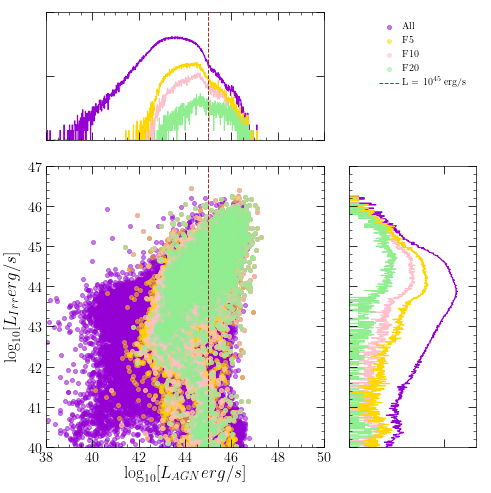

In [61]:
fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)


ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(l0Irr['LAGNerg'],l0Irr['LIrrerg'],c = 'darkviolet',label = 'All' ,alpha = 0.5)
ax.scatter(F5Irr['LAGNerg'],F5Irr['LIrrerg'],c = 'gold',label = 'F5' ,alpha = 0.5)
ax.scatter(F10Irr['LAGNerg'],F10Irr['LIrrerg'],c = 'pink',label = 'F10' ,alpha = 0.5)
ax.scatter(F20Irr['LAGNerg'],F20Irr['LIrrerg'],c = 'lightgreen',label = 'F20' ,alpha = 0.5)
ax.vlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$ \log_{10}[L_{Irr} erg/s]$')
ax.set_xlabel(r'$ \log_{10}[L_{AGN} erg/s]$')
ax.set_xlim(38, 50)
ax.set_ylim(40,47)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(l0Irr['LAGNerg'], bins=1000, histtype='step', color='darkviolet', density=False, lw=1, label="x", log=True)
ax.hist(F10Irr['LAGNerg'], bins=1000, histtype='step', color='pink', density=False, lw=1, label="x", log=True)
ax.hist(F5Irr['LAGNerg'], bins=1000, histtype='step', color='gold', density=False, lw=1, label="x", log=True)
ax.hist(F20Irr['LAGNerg'], bins=1000, histtype='step', color='lightgreen', density=False, lw=1, label="x", log=True)
ax.vlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(38, 50)
ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(l0Irr['LIrrerg'], bins=1000,orientation='horizontal', histtype='step', color='darkviolet', density=False, lw=1, label="y", log=True)
ax.hist(F10Irr['LIrrerg'], bins=1000,orientation='horizontal', histtype='step', color='pink', density=False, lw=1, label="y", log=True)
ax.hist(F5Irr['LIrrerg'], bins=1000,orientation='horizontal', histtype='step', color='gold', density=False, lw=1, label="y", log=True)
ax.hist(F20Irr['LIrrerg'], bins=1000,orientation='horizontal', histtype='step', color='lightgreen', density=False, lw=1, label="y", log=True)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(40,47)
ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)



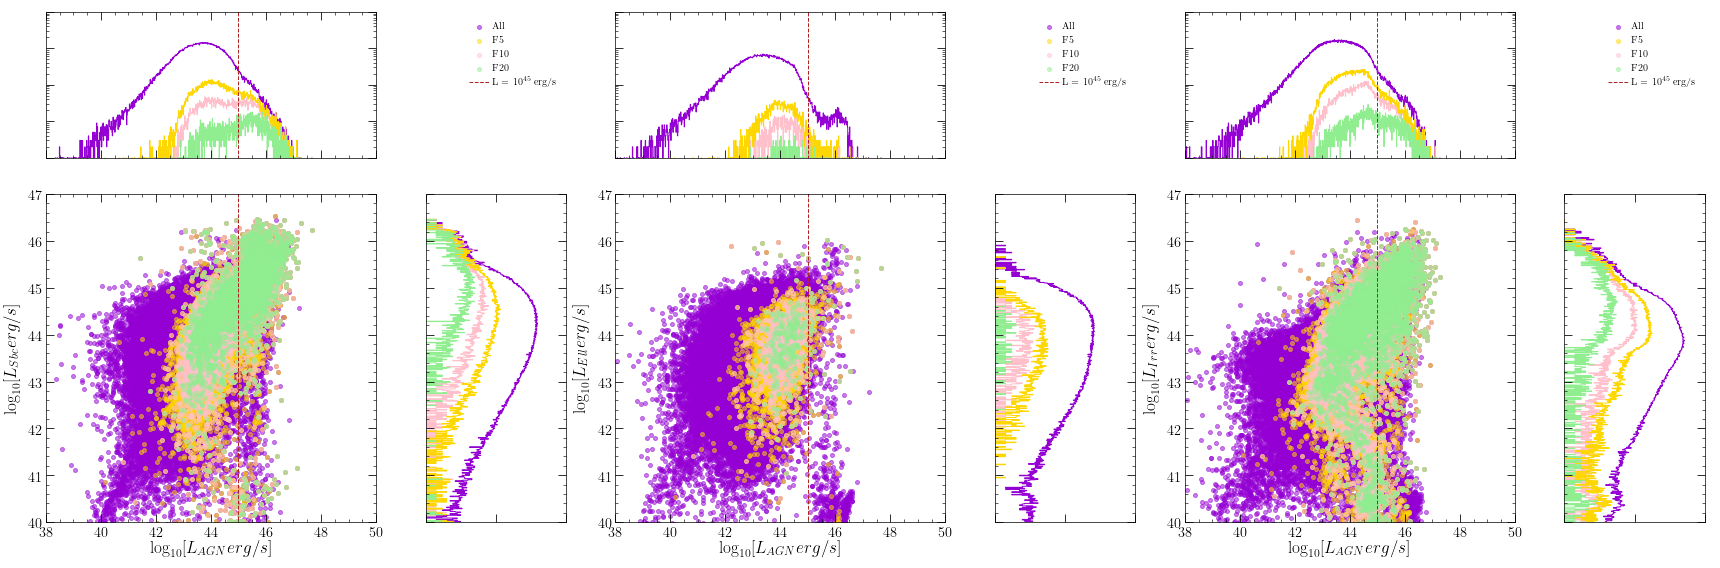

In [62]:
fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)


ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(l0Sbc['LAGNerg'],l0Sbc['LSbcerg'],c = 'darkviolet',label = 'All' ,alpha = 0.5)
ax.scatter(F5Sbc['LAGNerg'],F5Sbc['LSbcerg'],c = 'gold',label = 'F5' ,alpha = 0.5)
ax.scatter(F10Sbc['LAGNerg'],F10Sbc['LSbcerg'],c = 'pink',label = 'F10' ,alpha = 0.5)
ax.scatter(F20Sbc['LAGNerg'],F20Sbc['LSbcerg'],c = 'lightgreen',label = 'F20' ,alpha = 0.5)
ax.vlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$ \log_{10}[L_{Sbc} erg/s]$')
ax.set_xlabel(r'$ \log_{10}[L_{AGN} erg/s]$')
ax.set_xlim(38, 50)
ax.set_ylim(40,47)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(l0Sbc['LAGNerg'], bins=1000, histtype='step', color='darkviolet', density=False, lw=1, label="x", log=True)
ax.hist(F10Sbc['LAGNerg'], bins=1000, histtype='step', color='pink', density=False, lw=1, label="x", log=True)
ax.hist(F5Sbc['LAGNerg'], bins=1000, histtype='step', color='gold', density=False, lw=1, label="x", log=True)
ax.hist(F20Sbc['LAGNerg'], bins=1000, histtype='step', color='lightgreen', density=False, lw=1, label="x", log=True)
ax.vlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(38, 50)
ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(l0Sbc['LSbcerg'], bins=1000,orientation='horizontal', histtype='step', color='darkviolet', density=False, lw=1, label="y", log=True)
ax.hist(F10Sbc['LSbcerg'], bins=1000,orientation='horizontal', histtype='step', color='pink', density=False, lw=1, label="y", log=True)
ax.hist(F5Sbc['LSbcerg'], bins=1000,orientation='horizontal', histtype='step', color='gold', density=False, lw=1, label="y", log=True)
ax.hist(F20Sbc['LSbcerg'], bins=1000,orientation='horizontal', histtype='step', color='lightgreen', density=False, lw=1, label="y", log=True)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(40,47)
ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)


ax = fig.add_subplot(gs[1:, 3:5])
ax.scatter(l0Ell['LAGNerg'],l0Ell['LEllerg'],c = 'darkviolet',label = 'All' ,alpha = 0.5)
ax.scatter(F5Ell['LAGNerg'],F5Ell['LEllerg'],c = 'gold',label = 'F5' ,alpha = 0.5)
ax.scatter(F10Ell['LAGNerg'],F10Ell['LEllerg'],c = 'pink',label = 'F10' ,alpha = 0.5)
ax.scatter(F20Ell['LAGNerg'],F20Ell['LEllerg'],c = 'lightgreen',label = 'F20' ,alpha = 0.5)
ax.vlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$ \log_{10}[L_{Ell} erg/s]$')
ax.set_xlabel(r'$ \log_{10}[L_{AGN} erg/s]$')
ax.set_xlim(38, 50)
ax.set_ylim(40,47)
handles, labels = ax.get_legend_handles_labels()


ax = fig.add_subplot(gs[0, 5])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 3:5])
ax.hist(l0Ell['LAGNerg'], bins=1000, histtype='step', color='darkviolet', density=False, lw=1, label="x", log=True)
ax.hist(F10Ell['LAGNerg'], bins=1000, histtype='step', color='pink', density=False, lw=1, label="x", log=True)
ax.hist(F5Ell['LAGNerg'], bins=1000, histtype='step', color='gold', density=False, lw=1, label="x", log=True)
ax.hist(F20Ell['LAGNerg'], bins=1000, histtype='step', color='lightgreen', density=False, lw=1, label="x", log=True)
ax.vlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(38, 50)
ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)


ax = fig.add_subplot(gs[1:, 5])
ax.hist(l0Ell['LEllerg'], bins=1000,orientation='horizontal', histtype='step', color='darkviolet', density=False, lw=1, label="y", log=True)
ax.hist(F10Ell['LEllerg'], bins=1000,orientation='horizontal', histtype='step', color='pink', density=False, lw=1, label="y", log=True)
ax.hist(F5Ell['LEllerg'], bins=1000,orientation='horizontal', histtype='step', color='gold', density=False, lw=1, label="y", log=True)
ax.hist(F20Ell['LEllerg'], bins=1000,orientation='horizontal', histtype='step', color='lightgreen', density=False, lw=1, label="y", log=True)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(40,47)
ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)



ax = fig.add_subplot(gs[1:, 6:8])
ax.scatter(l0Irr['LAGNerg'],l0Irr['LIrrerg'],c = 'darkviolet',label = 'All' ,alpha = 0.5)
ax.scatter(F5Irr['LAGNerg'],F5Irr['LIrrerg'],c = 'gold',label = 'F5' ,alpha = 0.5)
ax.scatter(F10Irr['LAGNerg'],F10Irr['LIrrerg'],c = 'pink',label = 'F10' ,alpha = 0.5)
ax.scatter(F20Irr['LAGNerg'],F20Irr['LIrrerg'],c = 'lightgreen',label = 'F20' ,alpha = 0.5)
ax.vlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$ \log_{10}[L_{Irr} erg/s]$')
ax.set_xlabel(r'$ \log_{10}[L_{AGN} erg/s]$')
ax.set_xlim(38, 50)
ax.set_ylim(40,47)
handles, labels = ax.get_legend_handles_labels()


ax = fig.add_subplot(gs[0, 8])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 6:8])
ax.hist(l0Irr['LAGNerg'], bins=1000, histtype='step', color='darkviolet', density=False, lw=1, label="x", log=True)
ax.hist(F10Irr['LAGNerg'], bins=1000, histtype='step', color='pink', density=False, lw=1, label="x", log=True)
ax.hist(F5Irr['LAGNerg'], bins=1000, histtype='step', color='gold', density=False, lw=1, label="x", log=True)
ax.hist(F20Irr['LAGNerg'], bins=1000, histtype='step', color='lightgreen', density=False, lw=1, label="x", log=True)
ax.vlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(38, 50)
ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, -1])
ax.hist(l0Irr['LIrrerg'], bins=1000,orientation='horizontal', histtype='step', color='darkviolet', density=False, lw=1, label="y", log=True)
ax.hist(F10Irr['LIrrerg'], bins=1000,orientation='horizontal', histtype='step', color='pink', density=False, lw=1, label="y", log=True)
ax.hist(F5Irr['LIrrerg'], bins=1000,orientation='horizontal', histtype='step', color='gold', density=False, lw=1, label="y", log=True)
ax.hist(F20Irr['LIrrerg'], bins=1000,orientation='horizontal', histtype='step', color='lightgreen', density=False, lw=1, label="y", log=True)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(40,47)
ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)



plt.tight_layout()

[]

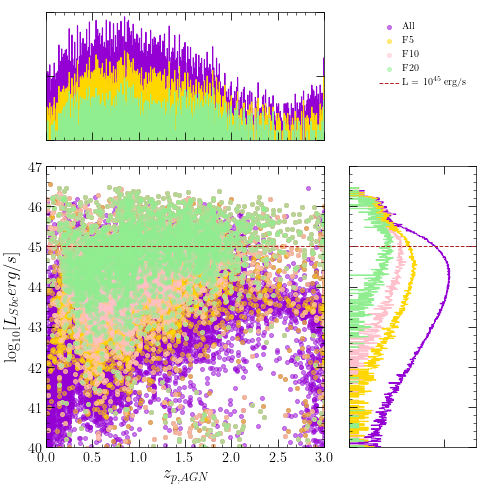

In [63]:
fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)


ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(l0Sbc['zGA'],l0Sbc['LSbcerg'],c = 'darkviolet',label = 'All' ,alpha = 0.5)
ax.scatter(F5Sbc['zGA'],F5Sbc['LSbcerg'],c = 'gold',label = 'F5' ,alpha = 0.5)
ax.scatter(F10Sbc['zGA'],F10Sbc['LSbcerg'],c = 'pink',label = 'F10' ,alpha = 0.5)
ax.scatter(F20Sbc['zGA'],F20Sbc['LSbcerg'],c = 'lightgreen',label = 'F20' ,alpha = 0.5)
ax.hlines(45, 0, 3, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$ \log_{10}[L_{Sbc} erg/s]$')
ax.set_xlabel(r'$z_{p,AGN}$')
ax.set_xlim(0, 3)
ax.set_ylim(40,47)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(l0Sbc['zGA'], bins=1000, histtype='step', color='darkviolet', density=False, lw=1, label="x", log=True)
ax.hist(F10Sbc['zGA'], bins=1000, histtype='step', color='pink', density=False, lw=1, label="x", log=True)
ax.hist(F5Sbc['zGA'], bins=1000, histtype='step', color='gold', density=False, lw=1, label="x", log=True)
ax.hist(F20Sbc['zGA'], bins=1000, histtype='step', color='lightgreen', density=False, lw=1, label="x", log=True)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(0, 3)
ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(l0Sbc['LSbcerg'], bins=1000,orientation='horizontal', histtype='step', color='darkviolet', density=False, lw=1, label="y", log=True)
ax.hist(F10Sbc['LSbcerg'], bins=1000,orientation='horizontal', histtype='step', color='pink', density=False, lw=1, label="y", log=True)
ax.hist(F5Sbc['LSbcerg'], bins=1000,orientation='horizontal', histtype='step', color='gold', density=False, lw=1, label="y", log=True)
ax.hist(F20Sbc['LSbcerg'], bins=1000,orientation='horizontal', histtype='step', color='lightgreen', density=False, lw=1, label="y", log=True)
ax.hlines(45, 10**0, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(40,47)
ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)



[]

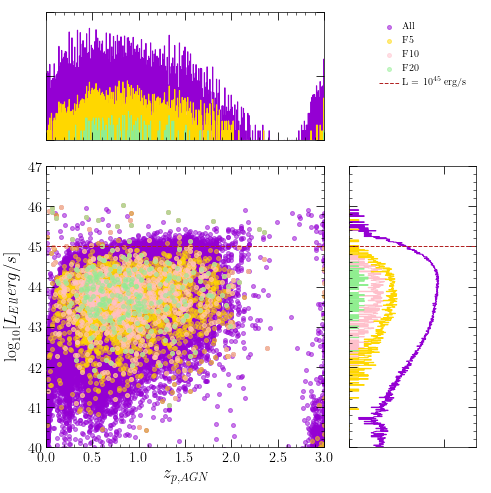

In [64]:
fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)


ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(l0Ell['zGA'],l0Ell['LEllerg'],c = 'darkviolet',label = 'All' ,alpha = 0.5)
ax.scatter(F5Ell['zGA'],F5Ell['LEllerg'],c = 'gold',label = 'F5' ,alpha = 0.5)
ax.scatter(F10Ell['zGA'],F10Ell['LEllerg'],c = 'pink',label = 'F10' ,alpha = 0.5)
ax.scatter(F20Ell['zGA'],F20Ell['LEllerg'],c = 'lightgreen',label = 'F20' ,alpha = 0.5)
ax.hlines(45, 0, 3, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$ \log_{10}[L_{Ell} erg/s]$')
ax.set_xlabel(r'$z_{p,AGN}$')
ax.set_xlim(0, 3)
ax.set_ylim(40,47)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(l0Ell['zGA'], bins=1000, histtype='step', color='darkviolet', density=False, lw=1, label="x", log=True)
ax.hist(F10Ell['zGA'], bins=1000, histtype='step', color='pink', density=False, lw=1, label="x", log=True)
ax.hist(F5Ell['zGA'], bins=1000, histtype='step', color='gold', density=False, lw=1, label="x", log=True)
ax.hist(F20Ell['zGA'], bins=1000, histtype='step', color='lightgreen', density=False, lw=1, label="x", log=True)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(0, 3)
ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(l0Ell['LEllerg'], bins=1000,orientation='horizontal', histtype='step', color='darkviolet', density=False, lw=1, label="y", log=True)
ax.hist(F10Ell['LEllerg'], bins=1000,orientation='horizontal', histtype='step', color='pink', density=False, lw=1, label="y", log=True)
ax.hist(F5Ell['LEllerg'], bins=1000,orientation='horizontal', histtype='step', color='gold', density=False, lw=1, label="y", log=True)
ax.hist(F20Ell['LEllerg'], bins=1000,orientation='horizontal', histtype='step', color='lightgreen', density=False, lw=1, label="y", log=True)
ax.hlines(45, 10**0, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(40,47)
ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)



[]

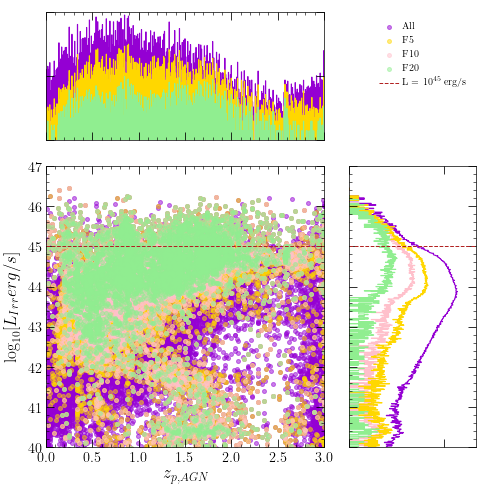

In [65]:
fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)


ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(l0Irr['zGA'],l0Irr['LIrrerg'],c = 'darkviolet',label = 'All' ,alpha = 0.5)
ax.scatter(F5Irr['zGA'],F5Irr['LIrrerg'],c = 'gold',label = 'F5' ,alpha = 0.5)
ax.scatter(F10Irr['zGA'],F10Irr['LIrrerg'],c = 'pink',label = 'F10' ,alpha = 0.5)
ax.scatter(F20Irr['zGA'],F20Irr['LIrrerg'],c = 'lightgreen',label = 'F20' ,alpha = 0.5)
ax.hlines(45, 0, 3, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$ \log_{10}[L_{Irr} erg/s]$')
ax.set_xlabel(r'$z_{p,AGN}$')
ax.set_xlim(0, 3)
ax.set_ylim(40,47)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(l0Irr['zGA'], bins=1000, histtype='step', color='darkviolet', density=False, lw=1, label="x", log=True)
ax.hist(F10Irr['zGA'], bins=1000, histtype='step', color='pink', density=False, lw=1, label="x", log=True)
ax.hist(F5Irr['zGA'], bins=1000, histtype='step', color='gold', density=False, lw=1, label="x", log=True)
ax.hist(F20Irr['zGA'], bins=1000, histtype='step', color='lightgreen', density=False, lw=1, label="x", log=True)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(0, 3)
ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(l0Irr['LIrrerg'], bins=1000,orientation='horizontal', histtype='step', color='darkviolet', density=False, lw=1, label="y", log=True)
ax.hist(F10Irr['LIrrerg'], bins=1000,orientation='horizontal', histtype='step', color='pink', density=False, lw=1, label="y", log=True)
ax.hist(F5Irr['LIrrerg'], bins=1000,orientation='horizontal', histtype='step', color='gold', density=False, lw=1, label="y", log=True)
ax.hist(F20Irr['LIrrerg'], bins=1000,orientation='horizontal', histtype='step', color='lightgreen', density=False, lw=1, label="y", log=True)
ax.hlines(45, 10**0, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(40,47)
ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)



[]

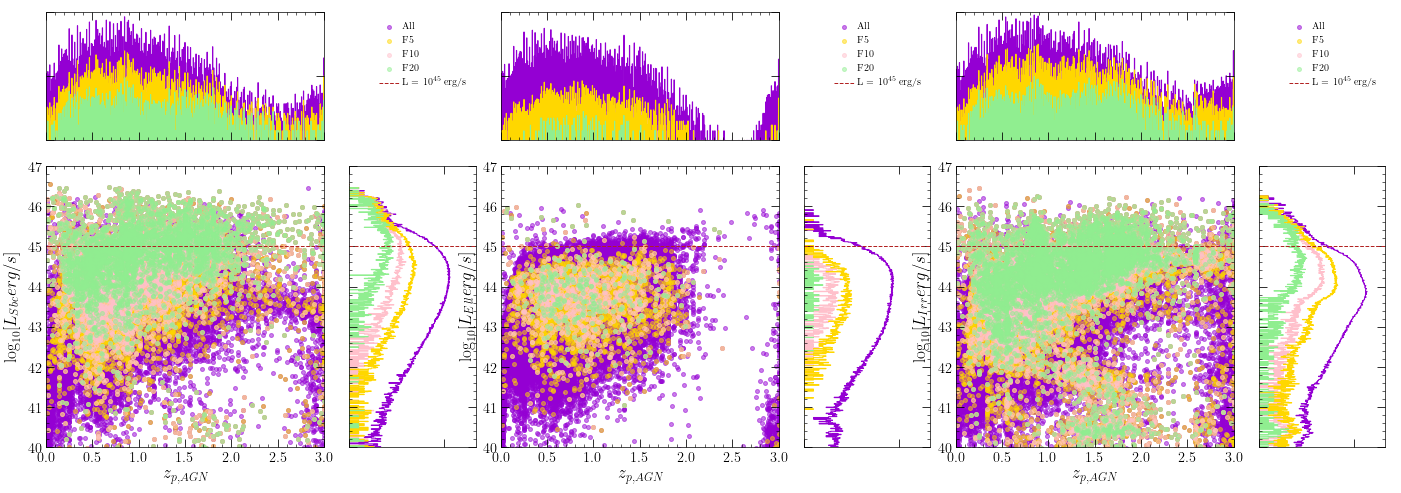

In [66]:
fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)

ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(l0Sbc['zGA'],l0Sbc['LSbcerg'],c = 'darkviolet',label = 'All' ,alpha = 0.5)
ax.scatter(F5Sbc['zGA'],F5Sbc['LSbcerg'],c = 'gold',label = 'F5' ,alpha = 0.5)
ax.scatter(F10Sbc['zGA'],F10Sbc['LSbcerg'],c = 'pink',label = 'F10' ,alpha = 0.5)
ax.scatter(F20Sbc['zGA'],F20Sbc['LSbcerg'],c = 'lightgreen',label = 'F20' ,alpha = 0.5)
ax.hlines(45, 0, 3, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$ \log_{10}[L_{Sbc} erg/s]$')
ax.set_xlabel(r'$z_{p,AGN}$')
ax.set_xlim(0, 3)
ax.set_ylim(40,47)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(l0Sbc['zGA'], bins=1000, histtype='step', color='darkviolet', density=False, lw=1, label="x", log=True)
ax.hist(F10Sbc['zGA'], bins=1000, histtype='step', color='pink', density=False, lw=1, label="x", log=True)
ax.hist(F5Sbc['zGA'], bins=1000, histtype='step', color='gold', density=False, lw=1, label="x", log=True)
ax.hist(F20Sbc['zGA'], bins=1000, histtype='step', color='lightgreen', density=False, lw=1, label="x", log=True)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(0, 3)
ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(l0Sbc['LSbcerg'], bins=1000,orientation='horizontal', histtype='step', color='darkviolet', density=False, lw=1, label="y", log=True)
ax.hist(F10Sbc['LSbcerg'], bins=1000,orientation='horizontal', histtype='step', color='pink', density=False, lw=1, label="y", log=True)
ax.hist(F5Sbc['LSbcerg'], bins=1000,orientation='horizontal', histtype='step', color='gold', density=False, lw=1, label="y", log=True)
ax.hist(F20Sbc['LSbcerg'], bins=1000,orientation='horizontal', histtype='step', color='lightgreen', density=False, lw=1, label="y", log=True)
ax.hlines(45, 10**0, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(40,47)
ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

#####

ax = fig.add_subplot(gs[1:, 3:5])
ax.scatter(l0Ell['zGA'],l0Ell['LEllerg'],c = 'darkviolet',label = 'All' ,alpha = 0.5)
ax.scatter(F5Ell['zGA'],F5Ell['LEllerg'],c = 'gold',label = 'F5' ,alpha = 0.5)
ax.scatter(F10Ell['zGA'],F10Ell['LEllerg'],c = 'pink',label = 'F10' ,alpha = 0.5)
ax.scatter(F20Ell['zGA'],F20Ell['LEllerg'],c = 'lightgreen',label = 'F20' ,alpha = 0.5)
ax.hlines(45, 0, 3, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$ \log_{10}[L_{Ell} erg/s]$')
ax.set_xlabel(r'$z_{p,AGN}$')
ax.set_xlim(0, 3)
ax.set_ylim(40,47)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 5])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 3:5])
ax.hist(l0Ell['zGA'], bins=1000, histtype='step', color='darkviolet', density=False, lw=1, label="x", log=True)
ax.hist(F10Ell['zGA'], bins=1000, histtype='step', color='pink', density=False, lw=1, label="x", log=True)
ax.hist(F5Ell['zGA'], bins=1000, histtype='step', color='gold', density=False, lw=1, label="x", log=True)
ax.hist(F20Ell['zGA'], bins=1000, histtype='step', color='lightgreen', density=False, lw=1, label="x", log=True)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(0, 3)
ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 5])
ax.hist(l0Ell['LEllerg'], bins=1000,orientation='horizontal', histtype='step', color='darkviolet', density=False, lw=1, label="y", log=True)
ax.hist(F10Ell['LEllerg'], bins=1000,orientation='horizontal', histtype='step', color='pink', density=False, lw=1, label="y", log=True)
ax.hist(F5Ell['LEllerg'], bins=1000,orientation='horizontal', histtype='step', color='gold', density=False, lw=1, label="y", log=True)
ax.hist(F20Ell['LEllerg'], bins=1000,orientation='horizontal', histtype='step', color='lightgreen', density=False, lw=1, label="y", log=True)
ax.hlines(45, 10**0, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(40,47)
ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)


####

ax = fig.add_subplot(gs[1:, 6:8])
ax.scatter(l0Irr['zGA'],l0Irr['LIrrerg'],c = 'darkviolet',label = 'All' ,alpha = 0.5)
ax.scatter(F5Irr['zGA'],F5Irr['LIrrerg'],c = 'gold',label = 'F5' ,alpha = 0.5)
ax.scatter(F10Irr['zGA'],F10Irr['LIrrerg'],c = 'pink',label = 'F10' ,alpha = 0.5)
ax.scatter(F20Irr['zGA'],F20Irr['LIrrerg'],c = 'lightgreen',label = 'F20' ,alpha = 0.5)
ax.hlines(45, 0, 3, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$ \log_{10}[L_{Irr} erg/s]$')
ax.set_xlabel(r'$z_{p,AGN}$')
ax.set_xlim(0, 3)
ax.set_ylim(40,47)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 8])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 6:8])
ax.hist(l0Irr['zGA'], bins=1000, histtype='step', color='darkviolet', density=False, lw=1, label="x", log=True)
ax.hist(F10Irr['zGA'], bins=1000, histtype='step', color='pink', density=False, lw=1, label="x", log=True)
ax.hist(F5Irr['zGA'], bins=1000, histtype='step', color='gold', density=False, lw=1, label="x", log=True)
ax.hist(F20Irr['zGA'], bins=1000, histtype='step', color='lightgreen', density=False, lw=1, label="x", log=True)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(0, 3)
ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, -1])
ax.hist(l0Irr['LIrrerg'], bins=1000,orientation='horizontal', histtype='step', color='darkviolet', density=False, lw=1, label="y", log=True)
ax.hist(F10Irr['LIrrerg'], bins=1000,orientation='horizontal', histtype='step', color='pink', density=False, lw=1, label="y", log=True)
ax.hist(F5Irr['LIrrerg'], bins=1000,orientation='horizontal', histtype='step', color='gold', density=False, lw=1, label="y", log=True)
ax.hist(F20Irr['LIrrerg'], bins=1000,orientation='horizontal', histtype='step', color='lightgreen', density=False, lw=1, label="y", log=True)
ax.hlines(45, 10**0, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(40,47)
ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)


[]

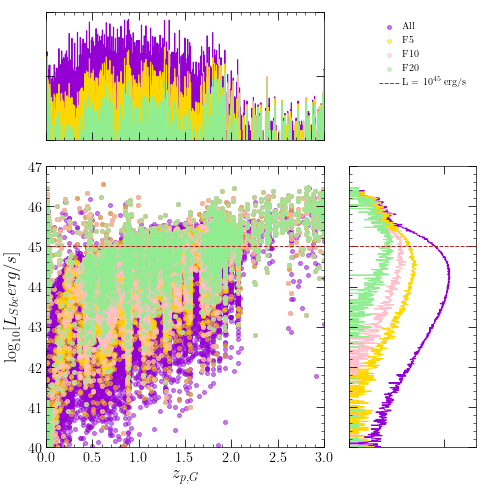

In [67]:
fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)


ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(l0Sbc['zG'],l0Sbc['LSbcerg'],c = 'darkviolet',label = 'All' ,alpha = 0.5)
ax.scatter(F5Sbc['zG'],F5Sbc['LSbcerg'],c = 'gold',label = 'F5' ,alpha = 0.5)
ax.scatter(F10Sbc['zG'],F10Sbc['LSbcerg'],c = 'pink',label = 'F10' ,alpha = 0.5)
ax.scatter(F20Sbc['zG'],F20Sbc['LSbcerg'],c = 'lightgreen',label = 'F20' ,alpha = 0.5)
ax.hlines(45, 0, 3, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$ \log_{10}[L_{Sbc} erg/s]$')
ax.set_xlabel(r'$z_{p,G}$')
ax.set_xlim(0, 3)
ax.set_ylim(40,47)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(l0Sbc['zG'], bins=1000, histtype='step', color='darkviolet', density=False, lw=1, label="x", log=True)
ax.hist(F10Sbc['zG'], bins=1000, histtype='step', color='pink', density=False, lw=1, label="x", log=True)
ax.hist(F5Sbc['zG'], bins=1000, histtype='step', color='gold', density=False, lw=1, label="x", log=True)
ax.hist(F20Sbc['zG'], bins=1000, histtype='step', color='lightgreen', density=False, lw=1, label="x", log=True)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(0, 3)
ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(l0Sbc['LSbcerg'], bins=1000,orientation='horizontal', histtype='step', color='darkviolet', density=False, lw=1, label="y", log=True)
ax.hist(F10Sbc['LSbcerg'], bins=1000,orientation='horizontal', histtype='step', color='pink', density=False, lw=1, label="y", log=True)
ax.hist(F5Sbc['LSbcerg'], bins=1000,orientation='horizontal', histtype='step', color='gold', density=False, lw=1, label="y", log=True)
ax.hist(F20Sbc['LSbcerg'], bins=1000,orientation='horizontal', histtype='step', color='lightgreen', density=False, lw=1, label="y", log=True)
ax.hlines(45, 10**0, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(40,47)
ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)



[]

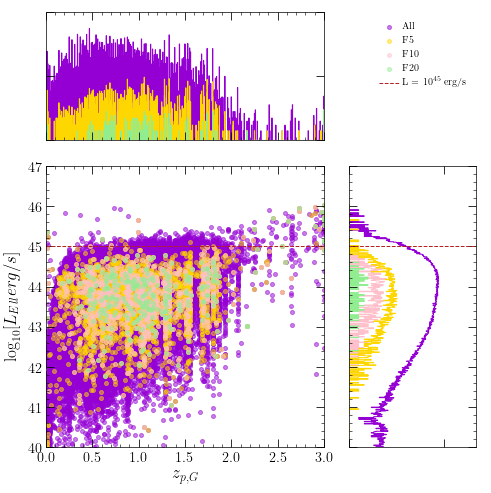

In [68]:
fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)


ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(l0Ell['zG'],l0Ell['LEllerg'],c = 'darkviolet',label = 'All' ,alpha = 0.5)
ax.scatter(F5Ell['zG'],F5Ell['LEllerg'],c = 'gold',label = 'F5' ,alpha = 0.5)
ax.scatter(F10Ell['zG'],F10Ell['LEllerg'],c = 'pink',label = 'F10' ,alpha = 0.5)
ax.scatter(F20Ell['zG'],F20Ell['LEllerg'],c = 'lightgreen',label = 'F20' ,alpha = 0.5)
ax.hlines(45, 0, 3, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$ \log_{10}[L_{Ell} erg/s]$')
ax.set_xlabel(r'$z_{p,G}$')
ax.set_xlim(0, 3)
ax.set_ylim(40,47)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(l0Ell['zG'], bins=1000, histtype='step', color='darkviolet', density=False, lw=1, label="x", log=True)
ax.hist(F10Ell['zG'], bins=1000, histtype='step', color='pink', density=False, lw=1, label="x", log=True)
ax.hist(F5Ell['zG'], bins=1000, histtype='step', color='gold', density=False, lw=1, label="x", log=True)
ax.hist(F20Ell['zG'], bins=1000, histtype='step', color='lightgreen', density=False, lw=1, label="x", log=True)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(0, 3)
ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(l0Ell['LEllerg'], bins=1000,orientation='horizontal', histtype='step', color='darkviolet', density=False, lw=1, label="y", log=True)
ax.hist(F10Ell['LEllerg'], bins=1000,orientation='horizontal', histtype='step', color='pink', density=False, lw=1, label="y", log=True)
ax.hist(F5Ell['LEllerg'], bins=1000,orientation='horizontal', histtype='step', color='gold', density=False, lw=1, label="y", log=True)
ax.hist(F20Ell['LEllerg'], bins=1000,orientation='horizontal', histtype='step', color='lightgreen', density=False, lw=1, label="y", log=True)
ax.hlines(45, 10**0, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(40,47)
ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)



[]

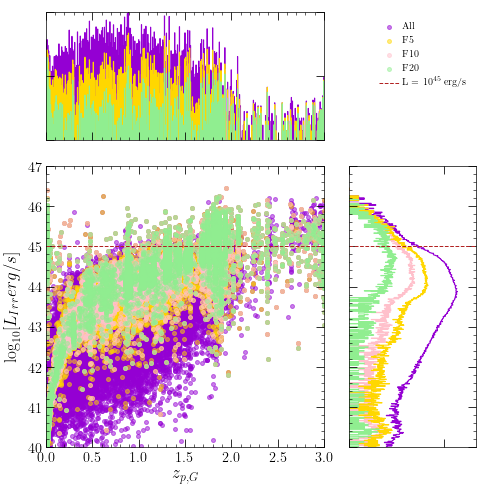

In [69]:
fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)


ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(l0Irr['zG'],l0Irr['LIrrerg'],c = 'darkviolet',label = 'All' ,alpha = 0.5)
ax.scatter(F5Irr['zG'],F5Irr['LIrrerg'],c = 'gold',label = 'F5' ,alpha = 0.5)
ax.scatter(F10Irr['zG'],F10Irr['LIrrerg'],c = 'pink',label = 'F10' ,alpha = 0.5)
ax.scatter(F20Irr['zG'],F20Irr['LIrrerg'],c = 'lightgreen',label = 'F20' ,alpha = 0.5)
ax.hlines(45, 0, 3, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$ \log_{10}[L_{Irr} erg/s]$')
ax.set_xlabel(r'$z_{p,G}$')
ax.set_xlim(0, 3)
ax.set_ylim(40,47)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(l0Irr['zG'], bins=1000, histtype='step', color='darkviolet', density=False, lw=1, label="x", log=True)
ax.hist(F10Irr['zG'], bins=1000, histtype='step', color='pink', density=False, lw=1, label="x", log=True)
ax.hist(F5Irr['zG'], bins=1000, histtype='step', color='gold', density=False, lw=1, label="x", log=True)
ax.hist(F20Irr['zG'], bins=1000, histtype='step', color='lightgreen', density=False, lw=1, label="x", log=True)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(0, 3)
ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(l0Irr['LIrrerg'], bins=1000,orientation='horizontal', histtype='step', color='darkviolet', density=False, lw=1, label="y", log=True)
ax.hist(F10Irr['LIrrerg'], bins=1000,orientation='horizontal', histtype='step', color='pink', density=False, lw=1, label="y", log=True)
ax.hist(F5Irr['LIrrerg'], bins=1000,orientation='horizontal', histtype='step', color='gold', density=False, lw=1, label="y", log=True)
ax.hist(F20Irr['LIrrerg'], bins=1000,orientation='horizontal', histtype='step', color='lightgreen', density=False, lw=1, label="y", log=True)
ax.hlines(45, 10**0, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(40,47)
ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)



[]

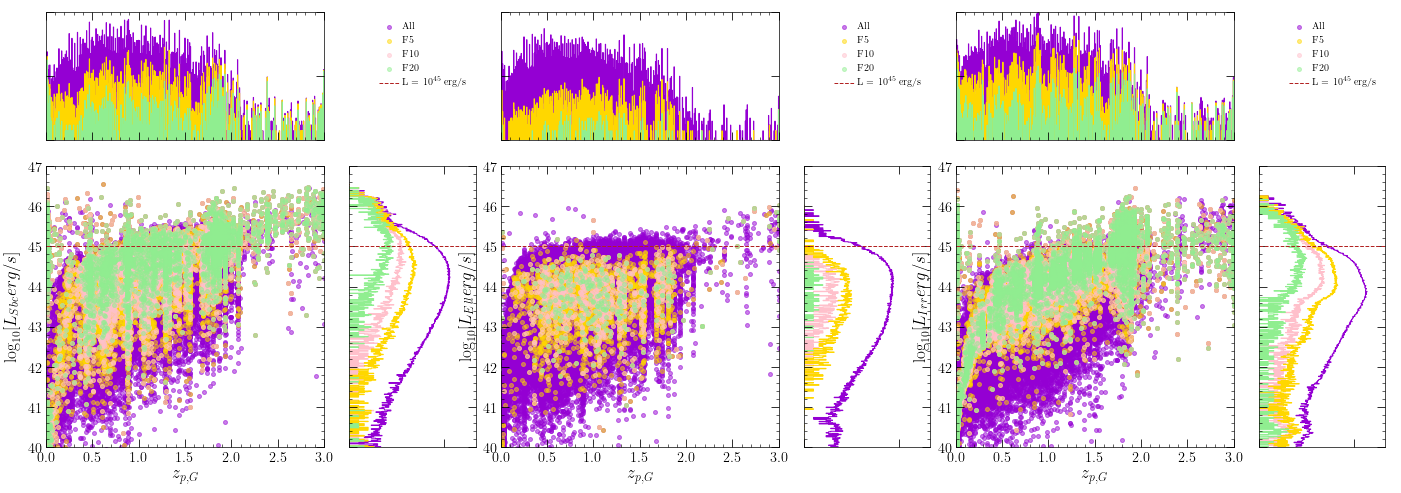

In [70]:
fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)

ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(l0Sbc['zG'],l0Sbc['LSbcerg'],c = 'darkviolet',label = 'All' ,alpha = 0.5)
ax.scatter(F5Sbc['zG'],F5Sbc['LSbcerg'],c = 'gold',label = 'F5' ,alpha = 0.5)
ax.scatter(F10Sbc['zG'],F10Sbc['LSbcerg'],c = 'pink',label = 'F10' ,alpha = 0.5)
ax.scatter(F20Sbc['zG'],F20Sbc['LSbcerg'],c = 'lightgreen',label = 'F20' ,alpha = 0.5)
ax.hlines(45, 0, 3, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$ \log_{10}[L_{Sbc} erg/s]$')
ax.set_xlabel(r'$z_{p,G}$')
ax.set_xlim(0, 3)
ax.set_ylim(40,47)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(l0Sbc['zG'], bins=1000, histtype='step', color='darkviolet', density=False, lw=1, label="x", log=True)
ax.hist(F10Sbc['zG'], bins=1000, histtype='step', color='pink', density=False, lw=1, label="x", log=True)
ax.hist(F5Sbc['zG'], bins=1000, histtype='step', color='gold', density=False, lw=1, label="x", log=True)
ax.hist(F20Sbc['zG'], bins=1000, histtype='step', color='lightgreen', density=False, lw=1, label="x", log=True)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(0, 3)
ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(l0Sbc['LSbcerg'], bins=1000,orientation='horizontal', histtype='step', color='darkviolet', density=False, lw=1, label="y", log=True)
ax.hist(F10Sbc['LSbcerg'], bins=1000,orientation='horizontal', histtype='step', color='pink', density=False, lw=1, label="y", log=True)
ax.hist(F5Sbc['LSbcerg'], bins=1000,orientation='horizontal', histtype='step', color='gold', density=False, lw=1, label="y", log=True)
ax.hist(F20Sbc['LSbcerg'], bins=1000,orientation='horizontal', histtype='step', color='lightgreen', density=False, lw=1, label="y", log=True)
ax.hlines(45, 10**0, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(40,47)
ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

###

ax = fig.add_subplot(gs[1:, 3:5])
ax.scatter(l0Ell['zG'],l0Ell['LEllerg'],c = 'darkviolet',label = 'All' ,alpha = 0.5)
ax.scatter(F5Ell['zG'],F5Ell['LEllerg'],c = 'gold',label = 'F5' ,alpha = 0.5)
ax.scatter(F10Ell['zG'],F10Ell['LEllerg'],c = 'pink',label = 'F10' ,alpha = 0.5)
ax.scatter(F20Ell['zG'],F20Ell['LEllerg'],c = 'lightgreen',label = 'F20' ,alpha = 0.5)
ax.hlines(45, 0, 3, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$ \log_{10}[L_{Ell} erg/s]$')
ax.set_xlabel(r'$z_{p,G}$')
ax.set_xlim(0, 3)
ax.set_ylim(40,47)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 5])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 3:5])
ax.hist(l0Ell['zG'], bins=1000, histtype='step', color='darkviolet', density=False, lw=1, label="x", log=True)
ax.hist(F10Ell['zG'], bins=1000, histtype='step', color='pink', density=False, lw=1, label="x", log=True)
ax.hist(F5Ell['zG'], bins=1000, histtype='step', color='gold', density=False, lw=1, label="x", log=True)
ax.hist(F20Ell['zG'], bins=1000, histtype='step', color='lightgreen', density=False, lw=1, label="x", log=True)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(0, 3)
ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 5])
ax.hist(l0Ell['LEllerg'], bins=1000,orientation='horizontal', histtype='step', color='darkviolet', density=False, lw=1, label="y", log=True)
ax.hist(F10Ell['LEllerg'], bins=1000,orientation='horizontal', histtype='step', color='pink', density=False, lw=1, label="y", log=True)
ax.hist(F5Ell['LEllerg'], bins=1000,orientation='horizontal', histtype='step', color='gold', density=False, lw=1, label="y", log=True)
ax.hist(F20Ell['LEllerg'], bins=1000,orientation='horizontal', histtype='step', color='lightgreen', density=False, lw=1, label="y", log=True)
ax.hlines(45, 10**0, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(40,47)
ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

###

ax = fig.add_subplot(gs[1:, 6:8])
ax.scatter(l0Irr['zG'],l0Irr['LIrrerg'],c = 'darkviolet',label = 'All' ,alpha = 0.5)
ax.scatter(F5Irr['zG'],F5Irr['LIrrerg'],c = 'gold',label = 'F5' ,alpha = 0.5)
ax.scatter(F10Irr['zG'],F10Irr['LIrrerg'],c = 'pink',label = 'F10' ,alpha = 0.5)
ax.scatter(F20Irr['zG'],F20Irr['LIrrerg'],c = 'lightgreen',label = 'F20' ,alpha = 0.5)
ax.hlines(45, 0, 3, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$ \log_{10}[L_{Irr} erg/s]$')
ax.set_xlabel(r'$z_{p,G}$')
ax.set_xlim(0, 3)
ax.set_ylim(40,47)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 8])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 6:8])
ax.hist(l0Irr['zG'], bins=1000, histtype='step', color='darkviolet', density=False, lw=1, label="x", log=True)
ax.hist(F10Irr['zG'], bins=1000, histtype='step', color='pink', density=False, lw=1, label="x", log=True)
ax.hist(F5Irr['zG'], bins=1000, histtype='step', color='gold', density=False, lw=1, label="x", log=True)
ax.hist(F20Irr['zG'], bins=1000, histtype='step', color='lightgreen', density=False, lw=1, label="x", log=True)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(0, 3)
ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, -1])
ax.hist(l0Irr['LIrrerg'], bins=1000,orientation='horizontal', histtype='step', color='darkviolet', density=False, lw=1, label="y", log=True)
ax.hist(F10Irr['LIrrerg'], bins=1000,orientation='horizontal', histtype='step', color='pink', density=False, lw=1, label="y", log=True)
ax.hist(F5Irr['LIrrerg'], bins=1000,orientation='horizontal', histtype='step', color='gold', density=False, lw=1, label="y", log=True)
ax.hist(F20Irr['LIrrerg'], bins=1000,orientation='horizontal', histtype='step', color='lightgreen', density=False, lw=1, label="y", log=True)
ax.hlines(45, 10**0, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(40,47)
ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)




In [71]:
F10 = lg0[lg0['F']>=10]
print (len(F10))
F5 = lg0[lg0['F']>=5]
print (len(F5))
F20 = lg0[lg0['F']>=20]
print (len(F20))

16907
41470
5760


[]

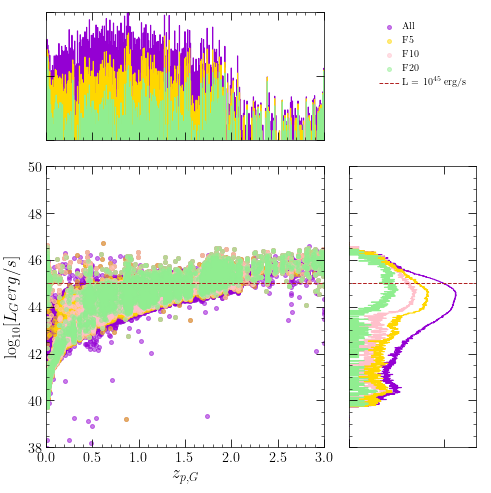

In [72]:
fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)


ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(lg0['zG'],lg0['LGlog'],c = 'darkviolet',label = 'All' ,alpha = 0.5)
ax.scatter(F5['zG'],F5['LGlog'],c = 'gold',label = 'F5' ,alpha = 0.5)
ax.scatter(F10['zG'],F10['LGlog'],c = 'pink',label = 'F10' ,alpha = 0.5)
ax.scatter(F20['zG'],F20['LGlog'],c = 'lightgreen',label = 'F20' ,alpha = 0.5)
ax.hlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$ \log_{10}[L_{G} erg/s]$')
ax.set_xlabel(r'$z_{p,G}$')
ax.set_xlim(0, 3)
ax.set_ylim(38,50)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(lg0['zG'], bins=1000, histtype='step', color='darkviolet', density=False, lw=1, label="x", log=True)
ax.hist(F10['zG'], bins=1000, histtype='step', color='pink', density=False, lw=1, label="x", log=True)
ax.hist(F5['zG'], bins=1000, histtype='step', color='gold', density=False, lw=1, label="x", log=True)
ax.hist(F20['zG'], bins=1000, histtype='step', color='lightgreen', density=False, lw=1, label="x", log=True)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(0, 3)
ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(lg0['LGlog'], bins=1000,orientation='horizontal', histtype='step', color='darkviolet', density=False, lw=1, label="y", log=True)
ax.hist(F10['LGlog'], bins=1000,orientation='horizontal', histtype='step', color='pink', density=False, lw=1, label="y", log=True)
ax.hist(F5['LGlog'], bins=1000,orientation='horizontal', histtype='step', color='gold', density=False, lw=1, label="y", log=True)
ax.hist(F20['LGlog'], bins=1000,orientation='horizontal', histtype='step', color='lightgreen', density=False, lw=1, label="y", log=True)
ax.hlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(38,50)
ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)



[]

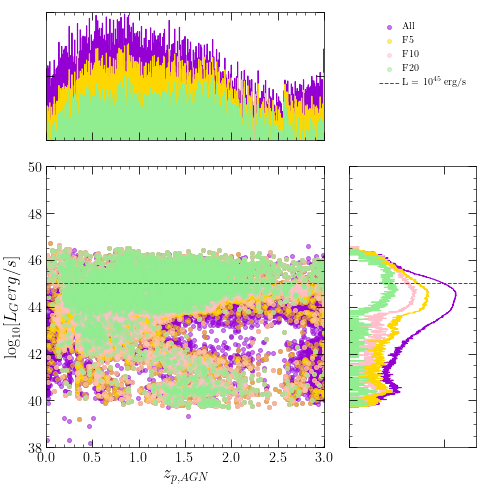

In [73]:
fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)


ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(lg0['zGA'],lg0['LGlog'],c = 'darkviolet',label = 'All' ,alpha = 0.5)
ax.scatter(F5['zGA'],F5['LGlog'],c = 'gold',label = 'F5' ,alpha = 0.5)
ax.scatter(F10['zGA'],F10['LGlog'],c = 'pink',label = 'F10' ,alpha = 0.5)
ax.scatter(F20['zGA'],F20['LGlog'],c = 'lightgreen',label = 'F20' ,alpha = 0.5)
ax.hlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$ \log_{10}[L_{G} erg/s]$')
ax.set_xlabel(r'$z_{p,AGN}$')
ax.set_xlim(0, 3)
ax.set_ylim(38,50)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(lg0['zGA'], bins=1000, histtype='step', color='darkviolet', density=False, lw=1, label="x", log=True)
ax.hist(F10['zGA'], bins=1000, histtype='step', color='pink', density=False, lw=1, label="x", log=True)
ax.hist(F5['zGA'], bins=1000, histtype='step', color='gold', density=False, lw=1, label="x", log=True)
ax.hist(F20['zGA'], bins=1000, histtype='step', color='lightgreen', density=False, lw=1, label="x", log=True)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(0, 3)
ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(lg0['LGlog'], bins=1000,orientation='horizontal', histtype='step', color='darkviolet', density=False, lw=1, label="y", log=True)
ax.hist(F10['LGlog'], bins=1000,orientation='horizontal', histtype='step', color='pink', density=False, lw=1, label="y", log=True)
ax.hist(F5['LGlog'], bins=1000,orientation='horizontal', histtype='step', color='gold', density=False, lw=1, label="y", log=True)
ax.hist(F20['LGlog'], bins=1000,orientation='horizontal', histtype='step', color='lightgreen', density=False, lw=1, label="y", log=True)
ax.hlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(38,50)
ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)



In [74]:
l0Sbcp = l0[l0['LSbcp']!=0.0]
l0Ellp = l0[l0['LELLp']!=0.0]
l0Irrp = l0[l0['LIrrp']!=0.0]

LSbcerg = MaskedColumn(name = "LSbcerg", data = ((l0Sbcp['LSbcp'])+43.58) , dtype=np.float64) # 44 or 43?
#l0Sbcp.add_column(LSbcerg)
l0Sbcp.replace_column('LSbcerg',LSbcerg)

LEllerg = MaskedColumn(name = "LEllerg", data = ((l0Ellp['LELLp'])+43.58) , dtype=np.float64) # 44 or 43?
#l0Ellp.add_column(LEllerg)
l0Ellp.replace_column('LEllerg',LEllerg)

LIrrerg = MaskedColumn(name = "LIrrerg", data = ((l0Irrp['LIrrp'])+43.58) , dtype=np.float64) # 44 or 43?
#l0Irrp.add_column(LIrrerg)
l0Irrp.replace_column('LIrrerg',LIrrerg)


In [75]:
F10Sbcp = l0Sbcp[l0Sbcp['F']>=10]
F5Sbcp = l0Sbcp[l0Sbcp['F']>=5]
F20Sbcp = l0Sbcp[l0Sbcp['F']>=20]

F10Ellp = l0Ellp[l0Ellp['F']>=10]
F5Ellp = l0Ellp[l0Ellp['F']>=5]
F20Ellp = l0Ellp[l0Ellp['F']>=20]

F10Irrp = l0Irrp[l0Irrp['F']>=10]
F5Irrp = l0Irrp[l0Irrp['F']>=5]
F20Irrp = l0Irrp[l0Irrp['F']>=20]


[]

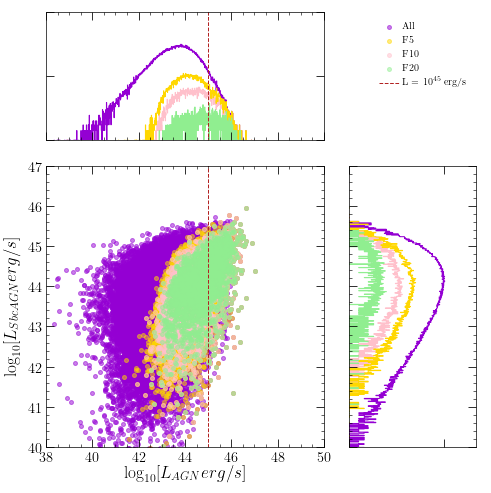

In [76]:
fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)


ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(l0Sbcp['LAGNerg'],l0Sbcp['LSbcerg'],c = 'darkviolet',label = 'All' ,alpha = 0.5)
ax.scatter(F5Sbcp['LAGNerg'],F5Sbcp['LSbcerg'],c = 'gold',label = 'F5' ,alpha = 0.5)
ax.scatter(F10Sbcp['LAGNerg'],F10Sbcp['LSbcerg'],c = 'pink',label = 'F10' ,alpha = 0.5)
ax.scatter(F20Sbcp['LAGNerg'],F20Sbcp['LSbcerg'],c = 'lightgreen',label = 'F20' ,alpha = 0.5)
ax.vlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$ \log_{10}[L_{SbcAGN} erg/s]$')
ax.set_xlabel(r'$ \log_{10}[L_{AGN} erg/s]$')
ax.set_xlim(38, 50)
ax.set_ylim(40,47)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(l0Sbcp['LAGNerg'], bins=1000, histtype='step', color='darkviolet', density=False, lw=1, label="x", log=True)
ax.hist(F10Sbcp['LAGNerg'], bins=1000, histtype='step', color='pink', density=False, lw=1, label="x", log=True)
ax.hist(F5Sbcp['LAGNerg'], bins=1000, histtype='step', color='gold', density=False, lw=1, label="x", log=True)
ax.hist(F20Sbcp['LAGNerg'], bins=1000, histtype='step', color='lightgreen', density=False, lw=1, label="x", log=True)
ax.vlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(38, 50)
ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(l0Sbcp['LSbcerg'], bins=1000,orientation='horizontal', histtype='step', color='darkviolet', density=False, lw=1, label="y", log=True)
ax.hist(F10Sbcp['LSbcerg'], bins=1000,orientation='horizontal', histtype='step', color='pink', density=False, lw=1, label="y", log=True)
ax.hist(F5Sbcp['LSbcerg'], bins=1000,orientation='horizontal', histtype='step', color='gold', density=False, lw=1, label="y", log=True)
ax.hist(F20Sbcp['LSbcerg'], bins=1000,orientation='horizontal', histtype='step', color='lightgreen', density=False, lw=1, label="y", log=True)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(40,47)
ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)



[]

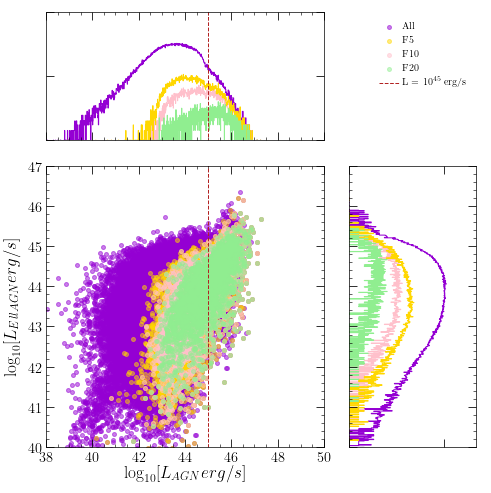

In [77]:
fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)


ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(l0Ellp['LAGNerg'],l0Ellp['LEllerg'],c = 'darkviolet',label = 'All' ,alpha = 0.5)
ax.scatter(F5Ellp['LAGNerg'],F5Ellp['LEllerg'],c = 'gold',label = 'F5' ,alpha = 0.5)
ax.scatter(F10Ellp['LAGNerg'],F10Ellp['LEllerg'],c = 'pink',label = 'F10' ,alpha = 0.5)
ax.scatter(F20Ellp['LAGNerg'],F20Ellp['LEllerg'],c = 'lightgreen',label = 'F20' ,alpha = 0.5)
ax.vlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$ \log_{10}[L_{EllAGN} erg/s]$')
ax.set_xlabel(r'$ \log_{10}[L_{AGN} erg/s]$')
ax.set_xlim(38, 50)
ax.set_ylim(40,47)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(l0Ellp['LAGNerg'], bins=1000, histtype='step', color='darkviolet', density=False, lw=1, label="x", log=True)
ax.hist(F10Ellp['LAGNerg'], bins=1000, histtype='step', color='pink', density=False, lw=1, label="x", log=True)
ax.hist(F5Ellp['LAGNerg'], bins=1000, histtype='step', color='gold', density=False, lw=1, label="x", log=True)
ax.hist(F20Ellp['LAGNerg'], bins=1000, histtype='step', color='lightgreen', density=False, lw=1, label="x", log=True)
ax.vlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(38, 50)
ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(l0Ellp['LEllerg'], bins=1000,orientation='horizontal', histtype='step', color='darkviolet', density=False, lw=1, label="y", log=True)
ax.hist(F10Ellp['LEllerg'], bins=1000,orientation='horizontal', histtype='step', color='pink', density=False, lw=1, label="y", log=True)
ax.hist(F5Ellp['LEllerg'], bins=1000,orientation='horizontal', histtype='step', color='gold', density=False, lw=1, label="y", log=True)
ax.hist(F20Ellp['LEllerg'], bins=1000,orientation='horizontal', histtype='step', color='lightgreen', density=False, lw=1, label="y", log=True)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(40,47)
ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)



[]

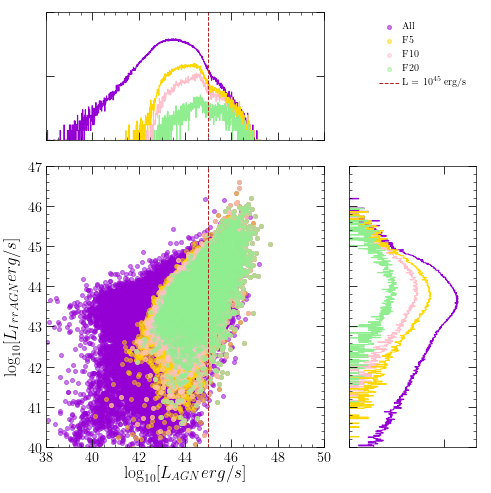

In [78]:
fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)


ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(l0Irrp['LAGNerg'],l0Irrp['LIrrerg'],c = 'darkviolet',label = 'All' ,alpha = 0.5)
ax.scatter(F5Irrp['LAGNerg'],F5Irrp['LIrrerg'],c = 'gold',label = 'F5' ,alpha = 0.5)
ax.scatter(F10Irrp['LAGNerg'],F10Irrp['LIrrerg'],c = 'pink',label = 'F10' ,alpha = 0.5)
ax.scatter(F20Irrp['LAGNerg'],F20Irrp['LIrrerg'],c = 'lightgreen',label = 'F20' ,alpha = 0.5)
ax.vlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$ \log_{10}[L_{IrrAGN} erg/s]$')
ax.set_xlabel(r'$ \log_{10}[L_{AGN} erg/s]$')
ax.set_xlim(38, 50)
ax.set_ylim(40,47)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(l0Irrp['LAGNerg'], bins=1000, histtype='step', color='darkviolet', density=False, lw=1, label="x", log=True)
ax.hist(F10Irrp['LAGNerg'], bins=1000, histtype='step', color='pink', density=False, lw=1, label="x", log=True)
ax.hist(F5Irrp['LAGNerg'], bins=1000, histtype='step', color='gold', density=False, lw=1, label="x", log=True)
ax.hist(F20Irrp['LAGNerg'], bins=1000, histtype='step', color='lightgreen', density=False, lw=1, label="x", log=True)
ax.vlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(38, 50)
ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(l0Irrp['LIrrerg'], bins=1000,orientation='horizontal', histtype='step', color='darkviolet', density=False, lw=1, label="y", log=True)
ax.hist(F10Irrp['LIrrerg'], bins=1000,orientation='horizontal', histtype='step', color='pink', density=False, lw=1, label="y", log=True)
ax.hist(F5Irrp['LIrrerg'], bins=1000,orientation='horizontal', histtype='step', color='gold', density=False, lw=1, label="y", log=True)
ax.hist(F20Irrp['LIrrerg'], bins=1000,orientation='horizontal', histtype='step', color='lightgreen', density=False, lw=1, label="y", log=True)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(40,47)
ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)



[]

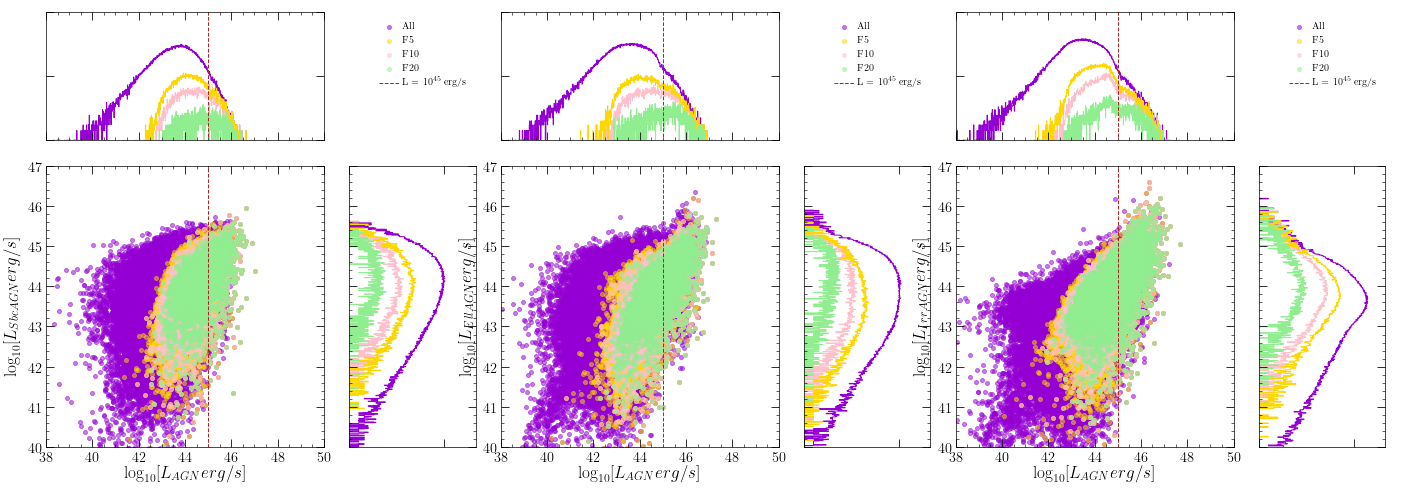

In [79]:
fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)


ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(l0Sbcp['LAGNerg'],l0Sbcp['LSbcerg'],c = 'darkviolet',label = 'All' ,alpha = 0.5)
ax.scatter(F5Sbcp['LAGNerg'],F5Sbcp['LSbcerg'],c = 'gold',label = 'F5' ,alpha = 0.5)
ax.scatter(F10Sbcp['LAGNerg'],F10Sbcp['LSbcerg'],c = 'pink',label = 'F10' ,alpha = 0.5)
ax.scatter(F20Sbcp['LAGNerg'],F20Sbcp['LSbcerg'],c = 'lightgreen',label = 'F20' ,alpha = 0.5)
ax.vlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$ \log_{10}[L_{SbcAGN} erg/s]$')
ax.set_xlabel(r'$ \log_{10}[L_{AGN} erg/s]$')
ax.set_xlim(38, 50)
ax.set_ylim(40,47)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(l0Sbcp['LAGNerg'], bins=1000, histtype='step', color='darkviolet', density=False, lw=1, label="x", log=True)
ax.hist(F10Sbcp['LAGNerg'], bins=1000, histtype='step', color='pink', density=False, lw=1, label="x", log=True)
ax.hist(F5Sbcp['LAGNerg'], bins=1000, histtype='step', color='gold', density=False, lw=1, label="x", log=True)
ax.hist(F20Sbcp['LAGNerg'], bins=1000, histtype='step', color='lightgreen', density=False, lw=1, label="x", log=True)
ax.vlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(38, 50)
ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(l0Sbcp['LSbcerg'], bins=1000,orientation='horizontal', histtype='step', color='darkviolet', density=False, lw=1, label="y", log=True)
ax.hist(F10Sbcp['LSbcerg'], bins=1000,orientation='horizontal', histtype='step', color='pink', density=False, lw=1, label="y", log=True)
ax.hist(F5Sbcp['LSbcerg'], bins=1000,orientation='horizontal', histtype='step', color='gold', density=False, lw=1, label="y", log=True)
ax.hist(F20Sbcp['LSbcerg'], bins=1000,orientation='horizontal', histtype='step', color='lightgreen', density=False, lw=1, label="y", log=True)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(40,47)
ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)


####

ax = fig.add_subplot(gs[1:, 3:5])
ax.scatter(l0Ellp['LAGNerg'],l0Ellp['LEllerg'],c = 'darkviolet',label = 'All' ,alpha = 0.5)
ax.scatter(F5Ellp['LAGNerg'],F5Ellp['LEllerg'],c = 'gold',label = 'F5' ,alpha = 0.5)
ax.scatter(F10Ellp['LAGNerg'],F10Ellp['LEllerg'],c = 'pink',label = 'F10' ,alpha = 0.5)
ax.scatter(F20Ellp['LAGNerg'],F20Ellp['LEllerg'],c = 'lightgreen',label = 'F20' ,alpha = 0.5)
ax.vlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$ \log_{10}[L_{EllAGN} erg/s]$')
ax.set_xlabel(r'$ \log_{10}[L_{AGN} erg/s]$')
ax.set_xlim(38, 50)
ax.set_ylim(40,47)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 5])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 3:5])
ax.hist(l0Ellp['LAGNerg'], bins=1000, histtype='step', color='darkviolet', density=False, lw=1, label="x", log=True)
ax.hist(F10Ellp['LAGNerg'], bins=1000, histtype='step', color='pink', density=False, lw=1, label="x", log=True)
ax.hist(F5Ellp['LAGNerg'], bins=1000, histtype='step', color='gold', density=False, lw=1, label="x", log=True)
ax.hist(F20Ellp['LAGNerg'], bins=1000, histtype='step', color='lightgreen', density=False, lw=1, label="x", log=True)
ax.vlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(38, 50)
ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 5])
ax.hist(l0Ellp['LEllerg'], bins=1000,orientation='horizontal', histtype='step', color='darkviolet', density=False, lw=1, label="y", log=True)
ax.hist(F10Ellp['LEllerg'], bins=1000,orientation='horizontal', histtype='step', color='pink', density=False, lw=1, label="y", log=True)
ax.hist(F5Ellp['LEllerg'], bins=1000,orientation='horizontal', histtype='step', color='gold', density=False, lw=1, label="y", log=True)
ax.hist(F20Ellp['LEllerg'], bins=1000,orientation='horizontal', histtype='step', color='lightgreen', density=False, lw=1, label="y", log=True)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(40,47)
ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

###

ax = fig.add_subplot(gs[1:, 6:8])
ax.scatter(l0Irrp['LAGNerg'],l0Irrp['LIrrerg'],c = 'darkviolet',label = 'All' ,alpha = 0.5)
ax.scatter(F5Irrp['LAGNerg'],F5Irrp['LIrrerg'],c = 'gold',label = 'F5' ,alpha = 0.5)
ax.scatter(F10Irrp['LAGNerg'],F10Irrp['LIrrerg'],c = 'pink',label = 'F10' ,alpha = 0.5)
ax.scatter(F20Irrp['LAGNerg'],F20Irrp['LIrrerg'],c = 'lightgreen',label = 'F20' ,alpha = 0.5)
ax.vlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$ \log_{10}[L_{IrrAGN} erg/s]$')
ax.set_xlabel(r'$ \log_{10}[L_{AGN} erg/s]$')
ax.set_xlim(38, 50)
ax.set_ylim(40,47)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 8])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 6:8])
ax.hist(l0Irrp['LAGNerg'], bins=1000, histtype='step', color='darkviolet', density=False, lw=1, label="x", log=True)
ax.hist(F10Irrp['LAGNerg'], bins=1000, histtype='step', color='pink', density=False, lw=1, label="x", log=True)
ax.hist(F5Irrp['LAGNerg'], bins=1000, histtype='step', color='gold', density=False, lw=1, label="x", log=True)
ax.hist(F20Irrp['LAGNerg'], bins=1000, histtype='step', color='lightgreen', density=False, lw=1, label="x", log=True)
ax.vlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(38, 50)
ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, -1])
ax.hist(l0Irrp['LIrrerg'], bins=1000,orientation='horizontal', histtype='step', color='darkviolet', density=False, lw=1, label="y", log=True)
ax.hist(F10Irrp['LIrrerg'], bins=1000,orientation='horizontal', histtype='step', color='pink', density=False, lw=1, label="y", log=True)
ax.hist(F5Irrp['LIrrerg'], bins=1000,orientation='horizontal', histtype='step', color='gold', density=False, lw=1, label="y", log=True)
ax.hist(F20Irrp['LIrrerg'], bins=1000,orientation='horizontal', histtype='step', color='lightgreen', density=False, lw=1, label="y", log=True)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(40,47)
ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)



In [80]:
LSbcergp = MaskedColumn(name = "LSbcergp", data = ((l0['LSbcp'])+43.58) , dtype=np.float64) # 44 or 43?
l0.add_column(LSbcergp)
#l0.replace_column('LSbcergp',LSbcergp)

LEllergp = MaskedColumn(name = "LEllergp", data = ((l0['LELLp'])+43.58) , dtype=np.float64) # 44 or 43?
l0.add_column(LEllergp)
#l0.replace_column('LEllergp',LEllergp)

LIrrergp = MaskedColumn(name = "LIrrergp", data = ((l0['LIrrp'])+43.58) , dtype=np.float64) # 44 or 43?
l0.add_column(LIrrergp)
#l0.replace_column('LIrrergp',LIrrergp)



#add columns unlogging 
LSbc1p = MaskedColumn(name = "LSbc1p", data = (10**(l0['LSbcergp'])) , dtype=np.float64) 
l0.add_column(LSbc1p)
#l0.replace_column('LSbc1p',LSbc1p)

LEll1p = MaskedColumn(name = "LEll1p", data = (10**(l0['LEllergp'])) , dtype=np.float64) 
l0.add_column(LEll1p)
#l0.replace_column('LEll1p',LEll1p)

LIrr1p = MaskedColumn(name = "LIrr1p", data = (10**(l0['LIrrergp'])) , dtype=np.float64) 
l0.add_column(LIrr1p)
#l0.replace_column('LIrr1p',LIrr1p)



#thennn add columns replacing 43.58 with 0
LSbc2p = MaskedColumn(name = "LSbc2p", data = (np.where(l0['LSbc1p']==10**43.58,0, l0['LSbc1p'])) , dtype=np.float64) 
l0.add_column(LSbc2p)
#l0.replace_column('LSbc2p',LSbc2p)

LEll2p = MaskedColumn(name = "LEll2p", data = (np.where(l0['LEll1p']==10**43.58,0, l0['LEll1p'])) , dtype=np.float64) 
l0.add_column(LEll2p)
#l0.replace_column('LEll2p',LEll2p)

LIrr2p = MaskedColumn(name = "LIrr2p", data = (np.where(l0['LIrr1p']==10**43.58,0, l0['LIrr1p'])) , dtype=np.float64) 
l0.add_column(LIrr2p)
#l0.replace_column('LIrr2p',LIrr2p)

#then add lg column (sum them)
Lgp = MaskedColumn(name = "Lgp", data = list(map(sum, zip(l0['LEll2p'],l0['LSbc2p'],l0['LIrr2p'])))  , dtype=np.float64)
l0.add_column(Lgp)
#l0.replace_column('Lgp',Lgp )



#then add log column 
LGlogp =  MaskedColumn(name = "LGlogp", data = np.log10(l0['Lgp']) , dtype=np.float64) 
l0.add_column(LGlogp)
#l0.replace_column('LGlogp',LGlogp)

#remove the values where they are all 0
lg0p = l0[[np.isfinite(l0['LGlogp'])]]

F10p = lg0p[lg0p['F']>=10]
F5p = lg0p[lg0p['F']>=5]
F20p = lg0p[lg0p['F']>=20]


print (len(lg0['LAGNerg']))
print (len(F5['LAGNerg']))
print (len(F10['LAGNerg']))
print (len(F20['LAGNerg']))

305254
41470
16907
5760


In [81]:
lg0p

<Table length=304560>
  RAdeg    DEdeg     Imag  ...          Lgp                 LGlogp      
 float64  float64  float64 ...        float64              float64      
--------- -------- ------- ... ---------------------- ------------------
217.18223 32.30523   22.77 ... 2.2284351492702984e+44             44.348
217.86705 32.30527   20.02 ... 1.5568881628517787e+44  44.19225741667808
217.88212 32.30531   22.67 ... 3.3728730865886787e+43             43.528
217.84705 32.30564   20.44 ... 1.0576190485583862e+45 45.024329264200276
217.70446 32.30566   19.34 ...  1.166809617060963e+43             43.067
217.48821 32.30604   19.71 ... 1.2302687708123711e+44 44.089999999999996
217.36268  32.3061   18.71 ...  8.053784411990643e+43             43.906
217.24316 32.30626   22.34 ...  4.879031049461457e+43  43.68833358190953
217.16662 32.30637   21.26 ...  8.752986876044035e+43 43.942156277300356
217.27482  32.3064   19.08 ... 1.2941958414499704e+45 45.111999999999995
      ...      ...     ... ...                    ...                ...
217.46691 35.83682   22.42 ... 3.4447352385475777e+43 43.537155847765696
216.45736 35.83683   22.78 ... 1.1426018653533838e+45 45.057894928732075
 217.3773 35.83683   20.35 ...  4.892614636610696e+44 44.689541010204174
218.31186 35.83712   21.96 ... 3.1856292205651465e+43   43.5031952263197
216.59854 35.83722   20.38 ... 1.1519772186425213e+44 44.061443890618726
216.62134  35.8374   20.51 ...  2.525883139036344e+44 44.402413253881356
218.37061 35.83753   22.02 ...  1.288771775629202e+44  44.11017601637553
216.61578 35.83764   21.39 ... 2.9648313895243513e+43             43.472
216.26838 35.83767   21.15 ... 2.0259406480733937e+44  44.30662671812605
216.17744 35.83784   22.95 ... 1.9522436658605136e+44  44.29053402241588

[]

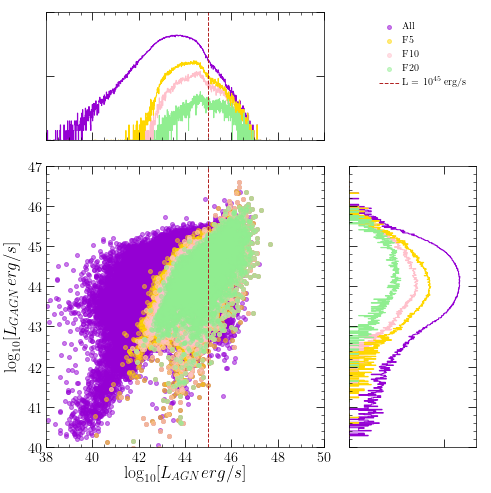

In [82]:
fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)


ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(lg0p['LAGNerg'],lg0p['LGlogp'],c = 'darkviolet',label = 'All' ,alpha = 0.5)
ax.scatter(F5p['LAGNerg'],F5p['LGlogp'],c = 'gold',label = 'F5' ,alpha = 0.5)
ax.scatter(F10p['LAGNerg'],F10p['LGlogp'],c = 'pink',label = 'F10' ,alpha = 0.5)
ax.scatter(F20p['LAGNerg'],F20p['LGlogp'],c = 'lightgreen',label = 'F20' ,alpha = 0.5)
ax.vlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$ \log_{10}[L_{GAGN} erg/s]$')
ax.set_xlabel(r'$ \log_{10}[L_{AGN} erg/s]$')
ax.set_xlim(38, 50)
ax.set_ylim(40,47)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(lg0p['LAGNerg'], bins=1000, histtype='step', color='darkviolet', density=False, lw=1, label="x", log=True)
ax.hist(F10p['LAGNerg'], bins=1000, histtype='step', color='pink', density=False, lw=1, label="x", log=True)
ax.hist(F5p['LAGNerg'], bins=1000, histtype='step', color='gold', density=False, lw=1, label="x", log=True)
ax.hist(F20p['LAGNerg'], bins=1000, histtype='step', color='lightgreen', density=False, lw=1, label="x", log=True)
ax.vlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(38, 50)
ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(lg0p['LGlogp'], bins=1000,orientation='horizontal', histtype='step', color='darkviolet', density=False, lw=1, label="y", log=True)
ax.hist(F10p['LGlogp'], bins=1000,orientation='horizontal', histtype='step', color='pink', density=False, lw=1, label="y", log=True)
ax.hist(F5p['LGlogp'], bins=1000,orientation='horizontal', histtype='step', color='gold', density=False, lw=1, label="y", log=True)
ax.hist(F20p['LGlogp'], bins=1000,orientation='horizontal', histtype='step', color='lightgreen', density=False, lw=1, label="y", log=True)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(40,47)
ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)



KeyError: 'LGlogp'

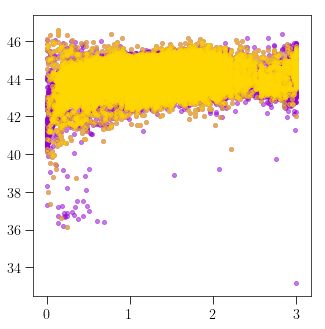

In [83]:
fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)


ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(lg0p['zGA'],lg0p['LGlogp'],c = 'darkviolet',label = 'All' ,alpha = 0.5)
ax.scatter(F5p['zGA'],F5p['LGlogp'],c = 'gold',label = 'F5' ,alpha = 0.5)
ax.scatter(F10p['zGA'],F10['LGlogp'],c = 'pink',label = 'F10' ,alpha = 0.5)
ax.scatter(F20p['zGA'],F20['LGlogp'],c = 'lightgreen',label = 'F20' ,alpha = 0.5)
ax.hlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$ \log_{10}[L_{GAGN} erg/s]$')
ax.set_xlabel(r'$z_{p,AGN}$')
ax.set_xlim(0, 3)
ax.set_ylim(38,50)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(lg0p['zGA'], bins=1000, histtype='step', color='darkviolet', density=False, lw=1, label="x", log=True)
ax.hist(F10p['zGA'], bins=1000, histtype='step', color='pink', density=False, lw=1, label="x", log=True)
ax.hist(F5p['zGA'], bins=1000, histtype='step', color='gold', density=False, lw=1, label="x", log=True)
ax.hist(F20p['zGA'], bins=1000, histtype='step', color='lightgreen', density=False, lw=1, label="x", log=True)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(0, 3)
ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(lg0p['LGlogp'], bins=1000,orientation='horizontal', histtype='step', color='darkviolet', density=False, lw=1, label="y", log=True)
ax.hist(F10p['LGlogp'], bins=1000,orientation='horizontal', histtype='step', color='pink', density=False, lw=1, label="y", log=True)
ax.hist(F5p['LGlogp'], bins=1000,orientation='horizontal', histtype='step', color='gold', density=False, lw=1, label="y", log=True)
ax.hist(F20p['LGlogp'], bins=1000,orientation='horizontal', histtype='step', color='lightgreen', density=False, lw=1, label="y", log=True)
ax.hlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(38,50)
ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)



In [ ]:
fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)

ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(l0Sbcp['zGA'],l0Sbcp['LSbcerg'],c = 'darkviolet',label = 'All' ,alpha = 0.5)
ax.scatter(F5Sbcp['zGA'],F5Sbcp['LSbcerg'],c = 'gold',label = 'F5' ,alpha = 0.5)
ax.scatter(F10Sbcp['zGA'],F10Sbcp['LSbcerg'],c = 'pink',label = 'F10' ,alpha = 0.5)
ax.scatter(F20Sbcp['zGA'],F20Sbcp['LSbcerg'],c = 'lightgreen',label = 'F20' ,alpha = 0.5)
ax.hlines(45, 0, 3, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$ \log_{10}[L_{SbcAGN} erg/s]$')
ax.set_xlabel(r'$z_{p,AGN}$')
ax.set_xlim(0, 3)
ax.set_ylim(40,47)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(l0Sbcp['zGA'], bins=1000, histtype='step', color='darkviolet', density=False, lw=1, label="x", log=True)
ax.hist(F10Sbcp['zGA'], bins=1000, histtype='step', color='pink', density=False, lw=1, label="x", log=True)
ax.hist(F5Sbcp['zGA'], bins=1000, histtype='step', color='gold', density=False, lw=1, label="x", log=True)
ax.hist(F20Sbcp['zGA'], bins=1000, histtype='step', color='lightgreen', density=False, lw=1, label="x", log=True)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(0, 3)
ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(l0Sbcp['LSbcerg'], bins=1000,orientation='horizontal', histtype='step', color='darkviolet', density=False, lw=1, label="y", log=True)
ax.hist(F10Sbcp['LSbcerg'], bins=1000,orientation='horizontal', histtype='step', color='pink', density=False, lw=1, label="y", log=True)
ax.hist(F5Sbcp['LSbcerg'], bins=1000,orientation='horizontal', histtype='step', color='gold', density=False, lw=1, label="y", log=True)
ax.hist(F20Sbcp['LSbcerg'], bins=1000,orientation='horizontal', histtype='step', color='lightgreen', density=False, lw=1, label="y", log=True)
ax.hlines(45, 10**0, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(40,47)
ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

#####

ax = fig.add_subplot(gs[1:, 3:5])
ax.scatter(l0Ellp['zGA'],l0Ellp['LEllerg'],c = 'darkviolet',label = 'All' ,alpha = 0.5)
ax.scatter(F5Ellp['zGA'],F5Ellp['LEllerg'],c = 'gold',label = 'F5' ,alpha = 0.5)
ax.scatter(F10Ellp['zGA'],F10Ellp['LEllerg'],c = 'pink',label = 'F10' ,alpha = 0.5)
ax.scatter(F20Ellp['zGA'],F20Ellp['LEllerg'],c = 'lightgreen',label = 'F20' ,alpha = 0.5)
ax.hlines(45, 0, 3, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$ \log_{10}[L_{EllAGN} erg/s]$')
ax.set_xlabel(r'$z_{p,AGN}$')
ax.set_xlim(0, 3)
ax.set_ylim(40,47)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 5])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 3:5])
ax.hist(l0Ellp['zGA'], bins=1000, histtype='step', color='darkviolet', density=False, lw=1, label="x", log=True)
ax.hist(F10Ellp['zGA'], bins=1000, histtype='step', color='pink', density=False, lw=1, label="x", log=True)
ax.hist(F5Ellp['zGA'], bins=1000, histtype='step', color='gold', density=False, lw=1, label="x", log=True)
ax.hist(F20Ellp['zGA'], bins=1000, histtype='step', color='lightgreen', density=False, lw=1, label="x", log=True)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(0, 3)
ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 5])
ax.hist(l0Ellp['LEllerg'], bins=1000,orientation='horizontal', histtype='step', color='darkviolet', density=False, lw=1, label="y", log=True)
ax.hist(F10Ellp['LEllerg'], bins=1000,orientation='horizontal', histtype='step', color='pink', density=False, lw=1, label="y", log=True)
ax.hist(F5Ellp['LEllerg'], bins=1000,orientation='horizontal', histtype='step', color='gold', density=False, lw=1, label="y", log=True)
ax.hist(F20Ellp['LEllerg'], bins=1000,orientation='horizontal', histtype='step', color='lightgreen', density=False, lw=1, label="y", log=True)
ax.hlines(45, 10**0, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(40,47)
ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)


####

ax = fig.add_subplot(gs[1:, 6:8])
ax.scatter(l0Irrp['zGA'],l0Irrp['LIrrerg'],c = 'darkviolet',label = 'All' ,alpha = 0.5)
ax.scatter(F5Irrp['zGA'],F5Irrp['LIrrerg'],c = 'gold',label = 'F5' ,alpha = 0.5)
ax.scatter(F10Irrp['zGA'],F10Irrp['LIrrerg'],c = 'pink',label = 'F10' ,alpha = 0.5)
ax.scatter(F20Irrp['zGA'],F20Irrp['LIrrerg'],c = 'lightgreen',label = 'F20' ,alpha = 0.5)
ax.hlines(45, 0, 3, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$ \log_{10}[L_{IrrAGN} erg/s]$')
ax.set_xlabel(r'$z_{p,AGN}$')
ax.set_xlim(0, 3)
ax.set_ylim(40,47)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 8])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 6:8])
ax.hist(l0Irrp['zGA'], bins=1000, histtype='step', color='darkviolet', density=False, lw=1, label="x", log=True)
ax.hist(F10Irrp['zGA'], bins=1000, histtype='step', color='pink', density=False, lw=1, label="x", log=True)
ax.hist(F5Irrp['zGA'], bins=1000, histtype='step', color='gold', density=False, lw=1, label="x", log=True)
ax.hist(F20Irrp['zGA'], bins=1000, histtype='step', color='lightgreen', density=False, lw=1, label="x", log=True)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_xlim(0, 3)
ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, -1])
ax.hist(l0Irrp['LIrrerg'], bins=1000,orientation='horizontal', histtype='step', color='darkviolet', density=False, lw=1, label="y", log=True)
ax.hist(F10Irrp['LIrrerg'], bins=1000,orientation='horizontal', histtype='step', color='pink', density=False, lw=1, label="y", log=True)
ax.hist(F5Irrp['LIrrerg'], bins=1000,orientation='horizontal', histtype='step', color='gold', density=False, lw=1, label="y", log=True)
ax.hist(F20Irrp['LIrrerg'], bins=1000,orientation='horizontal', histtype='step', color='lightgreen', density=False, lw=1, label="y", log=True)
ax.hlines(45, 10**0, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylim(40,47)
ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)


In [ ]:
lg0p.remove_columns(['LIrr2p', 'LEll2p', 'LSbc2p','LIrr1p','LEll1p','LSbc1p','LIrr2','LEll2','LSbc2','LIrr1','LEll1','LSbc1','SA','SType','Chi2S'])

In [ ]:
lg0p


In [ ]:
#new_table = lg0p([F, P, N45, spurious, spuriousfrac, nospurious])
from astropy.io import ascii
ascii.write(lg0p, 'lg0p1.fits', overwrite=True, comment = False, format = 'no_header')

In [ ]:
lg0p45 = lg0p[lg0p['LAGNerg']>=45]

In [ ]:
cut1045 = lg0p45[lg0p45['F']>=10]

In [ ]:
from astropy.io import ascii
ascii.write(cut1045, 'cut1045.fits', overwrite=True, comment = False, format = 'no_header')